In [1]:
import pandas as pd
import numpy as np
import re

# Disclaimer: help of artificial intelligence was used for assisting in making the code in this notebook
# Also the outputs might not match the ones from poster due to integrated training attributes count constraint for XGBregressor

In [2]:
df = pd.read_csv('carsdirectory_data.csv', low_memory=False)

In [3]:
# cleaning the exported dataset

# 1. renaming z-columns
df = df.rename(columns={
    'brand_freq': 'brand_freq_z',
    'brand_model_freq': 'brand_model_freq_z',
    'year_norm': 'year_z',
    'production_years_norm': 'production_years_z'
})

# 1. separating brand and model
# most are in format: "Mercedes-Benz C-class", "Ford F-150", "Audi A4"
df[['brand', 'model']] = df['brand_model'].str.split(' ', n=1, expand=True)

# in case of more spaces (nt "Land Rover Range Rover"), take the first word as brand
df['brand'] = df['brand_model'].str.split(' ').str[0]

# df['brand'] = df['brand_model'].str.extract(r'^([A-Za-z-]+(?: [A-Za-z-]+)?)')

# 2. converting horsepower → kW (1 hj = 0.73549875 kW) for consistency
if 'power_hp' in df.columns:
    df['power_kw'] = df['power_hp'] * 0.73549875
    df['power_kw'] = df['power_kw'].round(1)

# 4. checking results
print("New columns added:")
print(df[['brand_model', 'brand', 'model', 'power_hp', 'power_kw']].head(10))
df = df.drop(columns=['brand_model', 'power_hp', 'number_of_valves_per_cylinder', 'number_of_cylinders'], errors='ignore')

New columns added:
    brand_model   brand  model  power_hp  power_kw
0   Alpine A110  Alpine   A110      95.0      69.9
1        DAF 66     DAF     66      54.0      39.7
2   Alpine A110  Alpine   A110      90.0      66.2
3        DAF 66     DAF     66      57.0      41.9
4   Alpine A110  Alpine   A110     110.0      80.9
5   Alpine A110  Alpine   A110      70.0      51.5
6      AC Aceca      AC  Aceca     326.0     239.8
7  Daewoo Tosca  Daewoo  Tosca     142.0     104.4
8  Daewoo Racer  Daewoo  Racer      75.0      55.2
9  Daewoo Racer  Daewoo  Racer      75.0      55.2


In [4]:
# method for analysing data
def analyse_instances(df, low_fill_threshold=1.0, max_to_show=30, show_first_n=5):
    low_fill_columns = []
    
    print(f"Dataset: {len(df):,} rows × {len(df.columns)} columns\n")
    print("-" * 100)
    
    for i, col in enumerate(df.columns, 1):
        non_null_count = df[col].notna().sum()
        fill_percentage = non_null_count / len(df) * 100
        
        value_counts = df[col].value_counts(dropna=False).sort_values(ascending=False)
        total_unique = len(value_counts)
        
        flag = "⚠" if fill_percentage < low_fill_threshold else " "
        if flag == "⚠":
            low_fill_columns.append(col)
        
        print(f"{i:3d}. {flag} [{col}]")
        print(f"     Fill: {non_null_count:,} / {len(df):,} ({fill_percentage:.2f}%) | Unique: {total_unique:,}")
        
        if total_unique <= max_to_show:
            print("     Values:")
            for val, count in value_counts.items():
                if pd.isna(val):
                    print(f"       - <NaN>: {count:,}")
                elif str(val).strip() == "":
                    print(f"       - <empty string>: {count:,}")
                else:
                    print(f"       - {val}: {count:,}")
        else:
            print(f"     Too many unique values ({total_unique:,}), showing top {show_first_n}:")
            for val, count in value_counts.head(show_first_n).items():
                if pd.isna(val):
                    print(f"         - <NaN>: {count:,}")
                elif str(val).strip() == "":
                    print(f"         - <empty string>: {count:,}")
                else:
                    print(f"         - {val}: {count:,}")
            print(f"         ... and {total_unique - show_first_n:,} more unique values")
        print()

    if low_fill_columns:
        print(f"⚠ Columns with < {low_fill_threshold}% fill ({len(low_fill_columns)}):")
        print("    " + ", ".join(f"'{col}'" for col in low_fill_columns))
    else:
        print(f"All columns have greater than or equal to {low_fill_threshold}% fill rate.")
    
    return low_fill_columns

In [5]:
# executing search
low_fill_cols = analyse_instances(df, low_fill_threshold=5)

Dataset: 37,695 rows × 205 columns

----------------------------------------------------------------------------------------------------
  1.   [max_weight]
     Fill: 26,803 / 37,695 (71.10%) | Unique: 1,356
     Too many unique values (1,356), showing top 5:
         - <NaN>: 10,892
         - 2000.0: 288
         - 1870.0: 256
         - 1800.0: 246
         - 2050.0: 231
         ... and 1,351 more unique values

  2.   [length]
     Fill: 34,524 / 37,695 (91.59%) | Unique: 1,628
     Too many unique values (1,628), showing top 5:
         - <NaN>: 3,171
         - 4635.0: 200
         - 4765.0: 196
         - 4740.0: 195
         - 4796.0: 160
         ... and 1,623 more unique values

  3.   [width]
     Fill: 34,323 / 37,695 (91.05%) | Unique: 581
     Too many unique values (581), showing top 5:
         - <NaN>: 3,372
         - 1695.0: 1,096
         - 1810.0: 645
         - 1740.0: 570
         - 1690.0: 543
         ... and 576 more unique values

  4.   [height]
     Fill:

In [6]:
def analyze_non_numeric_columns(df, min_non_numeric_pct=1.0):
    """
    Leiab kõik tulbad, kus on vähemalt min_non_numeric_pct % mitte-arvulisi väärtusi.
    Näitab protsenti ja 10 kõige sagedasemat väärtust.
    
    Parameters:
        df: pandas DataFrame
        min_non_numeric_pct: kui palju protsentuaalselt peab olema mitte-arvuline (1.0 = kõik)
    """
    print("="*80)
    print(f"Non-numeric columns analysis (at least {min_non_numeric_pct*100:.0f}% are non-numeric)")
    print("="*80)
    
    non_numeric_info = []
    
    for col in df.columns:
        # trying to convert to numeric
        numeric_series = pd.to_numeric(df[col], errors='coerce')
        non_numeric_count = numeric_series.isna().sum()
        total_count = len(df[col])
        non_numeric_pct = non_numeric_count / total_count * 100
        
        # it there are enough non-numeric values
        if non_numeric_pct >= min_non_numeric_pct * 100:
            # Top 10 most frequent values
            top_values = df[col].value_counts(dropna=False).head(10)
            
            non_numeric_info.append({
                'column': col,
                'non_numeric_%': round(non_numeric_pct, 2),
                'total_rows': total_count,
                'non_numeric_count': non_numeric_count,
                'top_values': top_values
            })
    
    # sorting by non-numeric ones
    non_numeric_info = sorted(non_numeric_info, key=lambda x: x['non_numeric_%'], reverse=True)
    
    if not non_numeric_info:
        print("Didn't find any columns with enough non-numeric values")
        return
    
    for info in non_numeric_info:
        print(f"\n→ [{info['column']}]")
        print(f"   Non-numeric ones: {info['non_numeric_%']}% ({info['non_numeric_count']}/{info['total_rows']})")
        print("   Top 10 most frequent values:")
        for val, count in info['top_values'].items():
            print(f"      • {repr(val):30} → {count} times")
    
    print(f"\nFound in total: {len(non_numeric_info)} rows")
    return non_numeric_info

# showing all columns, where there are at least 1% non-numeric values
analyze_non_numeric_columns(df, min_non_numeric_pct=0.01)

Non-numeric columns analysis (at least 1% are non-numeric)

→ [powertrain_simple]
   Non-numeric ones: 100.0% (37695/37695)
   Top 10 most frequent values:
      • 'ICE'                          → 37168 times
      • 'Full_Hybrid'                  → 275 times
      • 'EV'                           → 245 times
      • 'FCEV'                         → 7 times

→ [fuel_simple]
   Non-numeric ones: 100.0% (37695/37695)
   Top 10 most frequent values:
      • 'Petrol'                       → 27251 times
      • 'Diesel'                       → 9585 times
      • 'Hybrid'                       → 290 times
      • 'EV'                           → 245 times
      • 'CNG/LPG'                      → 204 times
      • 'Flex_Fuel'                    → 99 times
      • 'Other'                        → 17 times
      • 'Hydrogen / electricity'       → 2 times
      • 'petrol / Ethanol - E85 / electricity' → 2 times

→ [brand]
   Non-numeric ones: 100.0% (37695/37695)
   Top 10 most frequent values:


[{'column': 'powertrain_simple',
  'non_numeric_%': np.float64(100.0),
  'total_rows': 37695,
  'non_numeric_count': np.int64(37695),
  'top_values': powertrain_simple
  ICE            37168
  Full_Hybrid      275
  EV               245
  FCEV               7
  Name: count, dtype: int64},
 {'column': 'fuel_simple',
  'non_numeric_%': np.float64(100.0),
  'total_rows': 37695,
  'non_numeric_count': np.int64(37695),
  'top_values': fuel_simple
  Petrol                                  27251
  Diesel                                   9585
  Hybrid                                    290
  EV                                        245
  CNG/LPG                                   204
  Flex_Fuel                                  99
  Other                                      17
  Hydrogen / electricity                      2
  petrol / Ethanol - E85 / electricity        2
  Name: count, dtype: int64},
 {'column': 'brand',
  'non_numeric_%': np.float64(100.0),
  'total_rows': 37695,
  'non_num

In [7]:
# method for cleaning data for permutation test

def clean_for_permutation_test(df):
    """
    - removes all _z columns
    - keeps only numerical and bool values
    - replaces NaNs with zeros
    """
    df = df.copy()
    
    # 1. removing z-columns, which turned out to be not necessary
    df = df.drop(columns=[c for c in df.columns if c.lower().endswith(('_z','_norm','_scaled','_minmax'))])

    # 2. choosing only numerical values + bool
    df = df.select_dtypes(include=['number', 'bool'])
    
    # 3. NaNs to zero
    df = df.fillna(0)
    
    print(f"Cleaned dataset for permutation test:")
    print(f"   - Rows in total: {df.shape[1]}")
    return df

Cleaned dataset for permutation test:
   - Rows in total: 79
Starting permutation test (100x)...
   Permutatsioon 1/100
   Permutatsioon 21/100
   Permutatsioon 41/100
   Permutatsioon 61/100
   Permutatsioon 81/100

Test statistic (maximum absolute Pearson correlation in original data):
→ |r|_max = 0.9754
   Stringest pair: front_overhang_mm  ↔  rear_overhang_mm


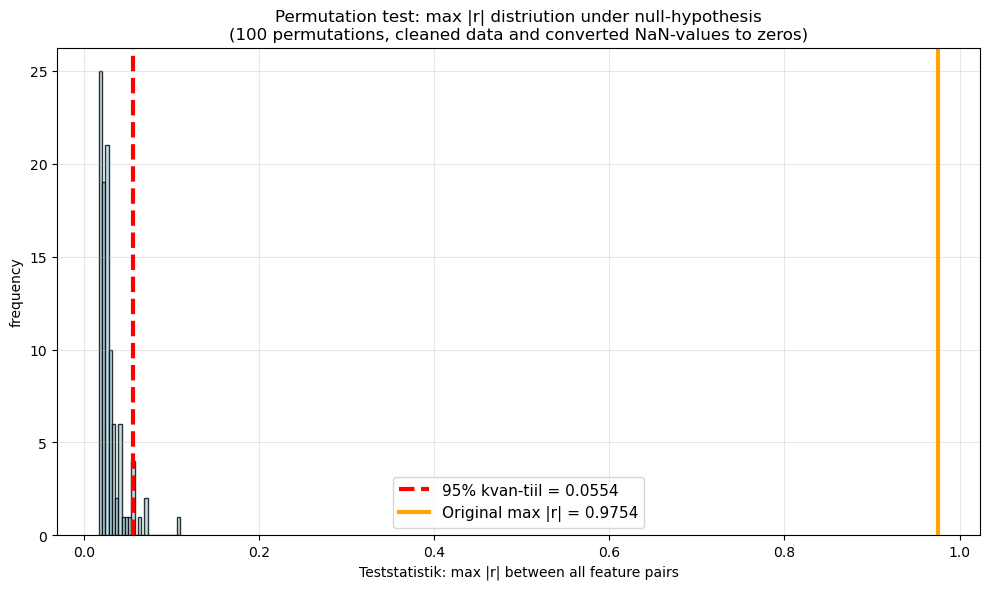


                     Permutation test result
Permutations:               100
Critical value (95%):     0.0554
Original max |r|:            0.9754
Stringest pair:                front_overhang_mm  ↔  rear_overhang_mm

→ 0.9754 > 0.0554 → H₀ debunked (p < 0.05)
   There is at least one real and statistically important correlation.

1669 statistically significant correlations (p < 0.05):
 Nr | Feature 1                           Feature 2                           |      |r|
--------------------------------------------------------------------------------------------------------------
  1. | front_overhang_mm                   rear_overhang_mm                    |   0.9754
  2. | departure_angle_deg                 approach_angle_deg                  |   0.9624
  3. | is_diesel                           is_petrol                           |   0.9432
  4. | fuel_extra_urban_l100km             fuel_urban_l100                     |   0.9420
  5. | cylinders                           displace

In [8]:
# =============================================================================
# Permutation test

import matplotlib.pyplot as plt
import numpy as np

# -------------------------------------------------------------------------
# contents cleaning
data_clean = df.drop(columns=['is_ice', 'valves_per_cyl', 
                              'number_of_valves_per_cylinder', 'number_of_cylinders'], 
                     errors='ignore') \
               .select_dtypes(include='number') \
               .fillna(0)

data_ready = clean_for_permutation_test(data_clean)

np.random.seed(1)

# ===================================================================
# a. Permutations – null-distribution (100x)
n_permutations = 100
max_abs_corrs_null = []

print("Starting permutation test (100x)...")

for i in range(n_permutations):
    if i % 20 == 0:
        print(f"   Permutatsioon {i+1}/{n_permutations}")

    shuffled = data_ready.copy()
    for col in shuffled.columns:
        np.random.shuffle(shuffled[col].values)

    corr_matrix = shuffled.corr().abs()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    upper_tri_values = corr_matrix.where(mask).stack()
    
    max_corr_this_perm = upper_tri_values.max()
    max_abs_corrs_null.append(max_corr_this_perm)

# finding critical values
threshold_95 = np.percentile(max_abs_corrs_null, 95)

# ===================================================================
# b. finding max |r| for original data
orig_corr = data_ready.corr().abs()
mask = np.triu(np.ones_like(orig_corr, dtype=bool), k=1)
upper_tri_corr = orig_corr.where(mask)

max_observed_corr = upper_tri_corr.stack().max()
strongest_pair = upper_tri_corr.stack().idxmax()

print(f"\nTest statistic (maximum absolute Pearson correlation in original data):")
print(f"→ |r|_max = {max_observed_corr:.4f}")
print(f"   Stringest pair: {strongest_pair[0]}  ↔  {strongest_pair[1]}")

# ===================================================================
# c. final graph with results and top pairs
plt.figure(figsize=(10, 6))
plt.hist(max_abs_corrs_null, bins=25, alpha=0.8, color='lightblue', edgecolor='black')
plt.axvline(threshold_95, color='red', linestyle='--', linewidth=3,
            label=f'95% kvan-tiil = {threshold_95:.4f}')
plt.axvline(max_observed_corr, color='orange', linewidth=3,
            label=f'Original max |r| = {max_observed_corr:.4f}')

plt.title('Permutation test: max |r| distriution under null-hypothesis\n'
          '(100 permutations, cleaned data and converted NaN-values to zeros)', fontsize=12)
plt.xlabel('Teststatistik: max |r| between all feature pairs')
plt.ylabel('frequency')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ===================================================================
# final result
print("\n" + "="*85)
print("                     Permutation test result")
print("="*85)
print(f"Permutations:               {n_permutations}")
print(f"Critical value (95%):     {threshold_95:.4f}")
print(f"Original max |r|:            {max_observed_corr:.4f}")
print(f"Stringest pair:                {strongest_pair[0]}  ↔  {strongest_pair[1]}")

if max_observed_corr > threshold_95:
    print(f"\n→ {max_observed_corr:.4f} > {threshold_95:.4f} → H₀ debunked (p < 0.05)")
    print("   There is at least one real and statistically important correlation.")
else:
    print(f"\n→ {max_observed_corr:.4f} ≤ {threshold_95:.4f} → There was not found any significant correlations")

# 1. finding significant pairs (which exeed the critical treshold)
significant = upper_tri_corr.stack()
significant = significant[significant > threshold_95].sort_values(ascending=False)

# 2. printing results
print(f"\n{len(significant)} statistically significant correlations (p < 0.05):")
print("="*110)
print(f"{'Nr':>3} | {'Feature 1':<35} {'Feature 2':<35} | {'|r|':>8}")
print("-"*110)

for i, ((col1, col2), corr_value) in enumerate(significant.items(), 1):
    print(f"{i:3}. | {col1:<35} {col2:<35} | {corr_value:8.4f}")

print("="*110)

Removing 25 unsignificatn features (|r|_max < 0.4)
There remains 54 active features



C:\Users\J\AppData\Local\Temp\ipykernel_3692\3544538294.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdYlGn')  # red-yello-green gradient


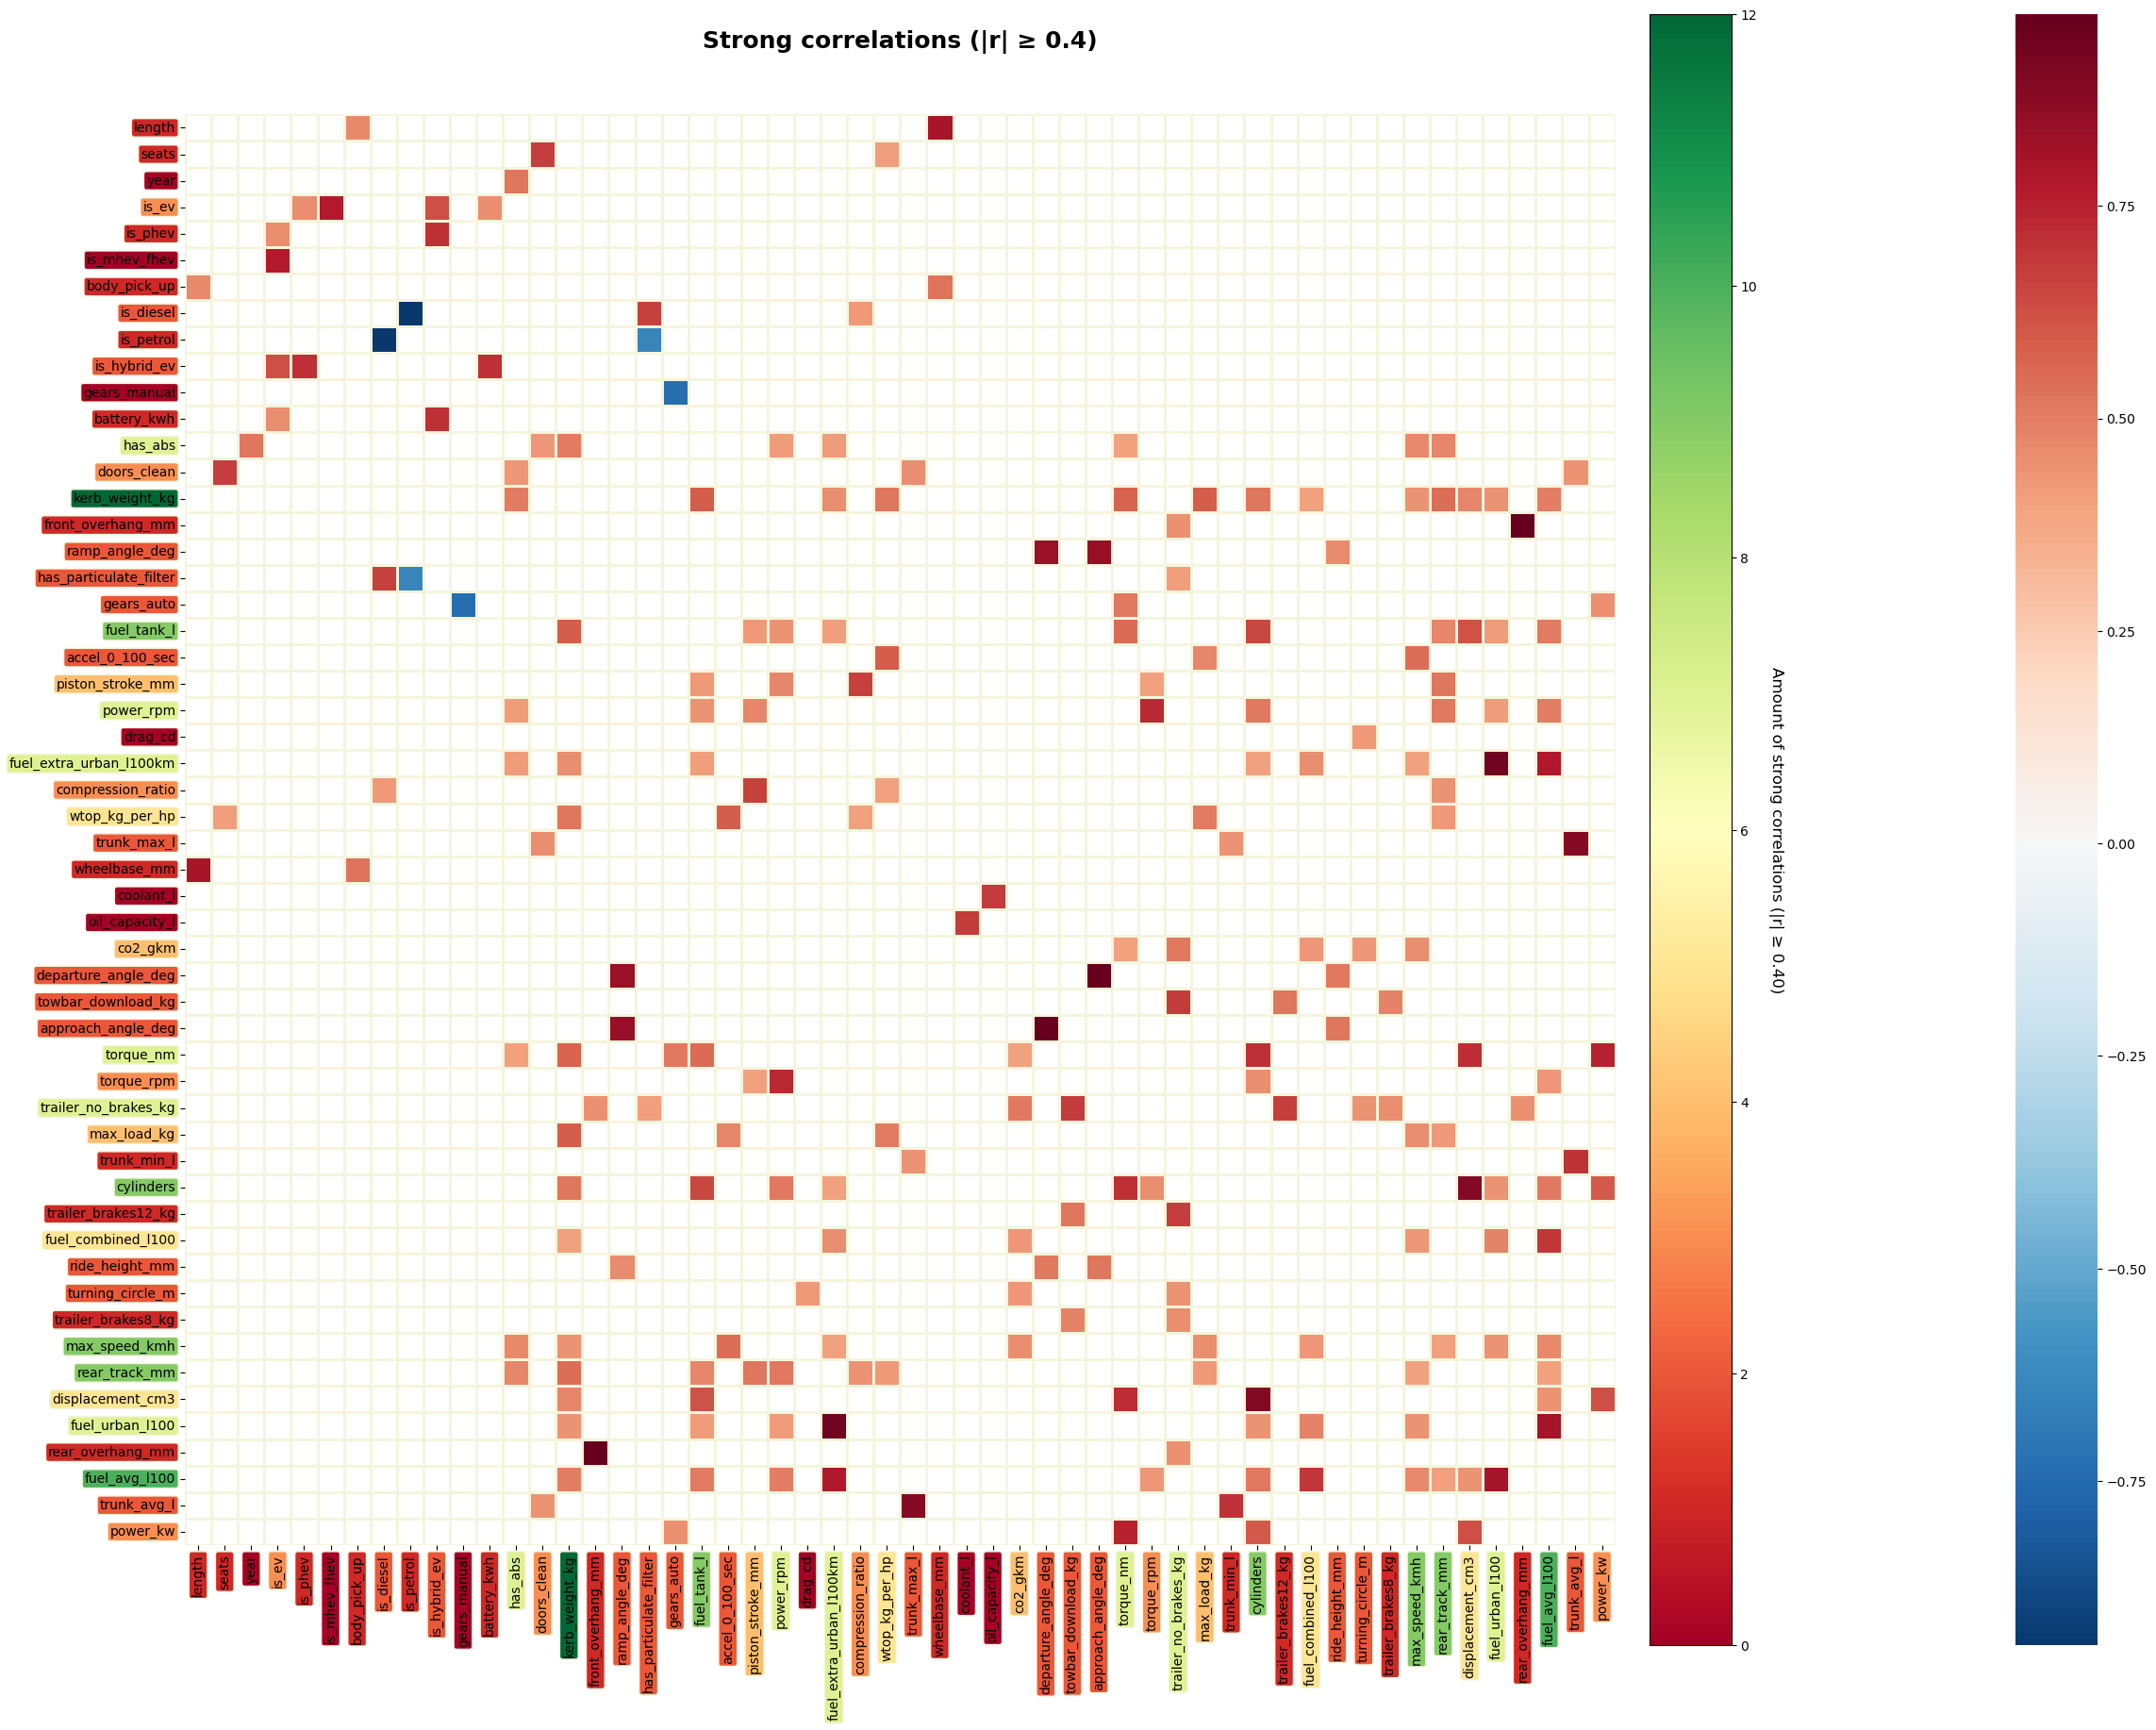

In [9]:
# ===================================================================
# heat map generation
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# treshold and filtering
threshold = 0.40
corr_abs = data_ready.corr().abs()
max_corr_per_feature = corr_abs.where(~np.eye(corr_abs.shape[0], dtype=bool)).max()
features_to_keep = max_corr_per_feature[max_corr_per_feature >= threshold].index.tolist()

print(f"Removing {len(corr_abs) - len(features_to_keep)} unsignificatn features (|r|_max < {threshold})")
print(f"There remains {len(features_to_keep)} active features\n")

corr_filtered = data_ready[features_to_keep].corr()

# Mask: hiding weak correlations and the sharp diagonal (which is not important)
mask = np.abs(corr_filtered) < threshold
np.fill_diagonal(mask.values, True)

# calculating the amount of relationships
row_counts = (~mask).sum(axis=1) - 1
col_counts = (~mask).sum(axis=0) - 1
connection_count = pd.DataFrame({'count': row_counts.combine(col_counts, max)})

# color scheme: green = lot of relatinoships, red = not so much
cmap = plt.cm.get_cmap('RdYlGn')  # red-yello-green gradient
norm = Normalize(vmin=connection_count['count'].min(), 
                 vmax=connection_count['count'].max())

# heatmap plotting
plt.figure(figsize=(25, 25))
g = sns.heatmap(corr_filtered,
                mask=mask,
                annot=False,
                fmt=".2f",
                cmap='RdBu_r',
                center=0,
                square=True,
                linewidths=0.8,
                linecolor='beige',
                cbar_kws={"shrink": 0.7})

# Lisa värviline ruut iga tunnuse nime kõrvale
# adding colored square markers besides the names of every significant feature, that was left
for tick in g.get_yticklabels():
    feat = tick.get_text()
    count = int(connection_count.loc[feat, 'count'])
    color = cmap(norm(count))
    tick.set_bbox(dict(facecolor=color, edgecolor='beige', boxstyle='round,pad=0.2'))

for tick in g.get_xticklabels():
    feat = tick.get_text()
    count = int(connection_count.loc[feat, 'count'])
    color = cmap(norm(count))
    tick.set_bbox(dict(facecolor=color, edgecolor='beige', boxstyle='round,pad=0.2'))

# adding the legend for context
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=g, shrink=0.7, pad=0.02)
cbar.set_label('Amount of strong correlations (|r| ≥ 0.40)', rotation=270, labelpad=20, fontsize=12)

plt.title(f'Strong correlations (|r| ≥ {threshold})\n',
          fontsize=18, fontweight='bold', pad=30)

plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

In [10]:
# first test
"""
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, precision_score, recall_score, accuracy_score

# -------------------------------------------------
# 1. Võtame andmestikust puhtad numbrilised ja bool väärtused
df_clean = df.select_dtypes(include=['number', 'bool']).copy()

# -------------------------------------------------
# 2. Sihtmärk: kas kütusekulu ≥ 7.0 L/100km
threshold = 7.0
df_clean['high_fuel'] = (df_clean['fuel_avg_l100'] >= threshold).astype(int)

print("Klasside jaotus:")
print(df_clean['high_fuel'].value_counts(normalize=True).round(3))

# -------------------------------------------------
# 3. Emaldame kõik lekkivad ja peidetud tulbad
leakage = [
    'power_hp', 'power_hp_z',
    'kerb_weight_kg', 'kerb_weight_kg_z',
    'displacement_cm3', 'displacement_z',
    'cylinders', 'cylinders_z',
]

# 1) Otsesed kütuse- ja CO2-tulbad
fuel_co2 = ['fuel_avg_l100', 'fuel_combined_l100', 'fuel_urban_l100', 
            'fuel_extra_urban_l100km', 'co2_gkm', 'co2_gkm_z']
leakage.extend(fuel_co2)

# 2) KÕIK z-score tulbad (lõpevad _z)
z_cols = [col for col in df_clean.columns if col.endswith('_z')]
leakage.extend(z_cols)

# 3) wtop tulbad (kaal per hj)
wtop_cols = [col for col in df_clean.columns if 'wtop' in col.lower()]
leakage.extend(wtop_cols)

# Eemaldame duplikaadid ja alles jäänud sihtmärgi
leakage = list(set(leakage))
leakage.append('high_fuel')

# Ainult olemasolevad tulbad
existing_leakage = [col for col in leakage if col in df_clean.columns]

print(f"\nRemoving {len(existing_leakage)} leaking columns (inc all _z ja wtop columns)")

X = df_clean.drop(columns=existing_leakage)
y = df_clean['high_fuel']

print(f"Remaining clean attributes: {X.shape[1]}.")

# -------------------------------------------------
# 4. Puuduvate väärtuste täitmine (lihtsaim ja töökindel viis)
X = X.fillna(X.median(numeric_only=True))        # numbrilised → mediaan
X = X.fillna(X.mode().iloc[0])                   # bool ja ülejäänud → kõige sagedasem
print("Missing values filled!")

# -------------------------------------------------
# 5. Train /20/20 jaotus
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

print(f"\nAndmed jagatud:")
print(f"  Train: {len(X_train):,} | Validation: {len(X_val):,} | Test: {len(X_test):,}")

# -------------------------------------------------
# 6. Treenime mudeli
rf = RandomForestClassifier(
    n_estimators=800,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    max_depth=None,
    min_samples_leaf=1
)
rf.fit(X_train, y_train)
print("\nModel trained!")

# -------------------------------------------------
# 7. Parim cutoff valideerimisel
val_proba = rf.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, val_proba)
J = tpr - fpr
best_idx = np.argmax(J)
best_threshold = thresholds[best_idx]

print(f"\nBest cutoff on validation: {best_threshold:.3f} (TPR={tpr[best_idx]:.3f}, FPR={fpr[best_idx]:.3f})")

# -------------------------------------------------
# 8. Lõplik testitulemus
test_proba = rf.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= best_threshold)

print(f"\nResults on test data:")
print(f"  AUC         : {roc_auc_score(y_test, test_proba):.4f}")
print(f"  Accuracy    : {accuracy_score(y_test, test_pred):.4f}")
print(f"  Precision   : {precision_score(y_test, test_pred):.4f}")
print(f"  Recall      : {recall_score(y_test, test_pred):.4f}")

# -------------------------------------------------
# 9. ROC-kõver
# -------------------------------------------------
plt.figure(figsize=(9,7))
fpr_test, tpr_test, _ = roc_curve(y_test, test_proba)
RocCurveDisplay(fpr=fpr_test, tpr=tpr_test).plot(ax=plt.gca(), name='Random Forest')
plt.plot(fpr[best_idx], tpr[best_idx], 'ro', markersize=12, 
         label=f'Parim cutoff (val) = {best_threshold:.3f}')
plt.title(f'Testandmete ROC-kõver – AUC = {roc_auc_score(y_test, test_proba):.4f}')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
"""

'\nimport matplotlib.pyplot as plt\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, precision_score, recall_score, accuracy_score\n\n# -------------------------------------------------\n# 1. Võtame andmestikust puhtad numbrilised ja bool väärtused\ndf_clean = df.select_dtypes(include=[\'number\', \'bool\']).copy()\n\n# -------------------------------------------------\n# 2. Sihtmärk: kas kütusekulu ≥ 7.0 L/100km\nthreshold = 7.0\ndf_clean[\'high_fuel\'] = (df_clean[\'fuel_avg_l100\'] >= threshold).astype(int)\n\nprint("Klasside jaotus:")\nprint(df_clean[\'high_fuel\'].value_counts(normalize=True).round(3))\n\n# -------------------------------------------------\n# 3. Emaldame kõik lekkivad ja peidetud tulbad\nleakage = [\n    \'power_hp\', \'power_hp_z\',\n    \'kerb_weight_kg\', \'kerb_weight_kg_z\',\n    \'displacement_cm3\', \'displacement_z\',\n    \'cyli

In [11]:
# regression test
"""
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------------------------------
# 1. Puhasta andmed
df_clean = df.select_dtypes(include=['number', 'bool']).copy()

# -------------------------------------------------
# 2. Sihtmärk on nüüd PIDEV arv – fuel_avg_l100
y = df_clean['fuel_avg_l100'].copy()           # <--- see ongi meie sihtmärk!
X = df_clean.drop(columns=['fuel_avg_l100'])   # eemaldame ainult sihtmärgi ise

# -------------------------------------------------
# 3. Täiesti aus tunnuste puhastus (kõik lekked eemale!)
leakage = [
    'fuel_combined_l100', 'fuel_urban_l100', 'fuel_extra_urban_l100km',
    'co2_gkm', 'co2_gkm_z',
    'power_hp', 'power_hp_z',
    'kerb_weight_kg', 'kerb_weight_kg_z',
    'displacement_cm3', 'displacement_z',
    'cylinders', 'cylinders_z',
]

z_cols = [col for col in X.columns if col.endswith('_z')]
wtop_cols = [col for col in X.columns if 'wtop' in col.lower()]
leakage = list(set(leakage + z_cols + wtop_cols))

existing_leakage = [col for col in leakage if col in X.columns]
print(f"Eemaldan {len(existing_leakage)} lekkivat tulp(a)")

X = X.drop(columns=existing_leakage)

# -------------------------------------------------
# 4. Puuduvate väärtuste täitmine
X = X.fillna(X.median(numeric_only=True))
X = X.fillna(X.mode().iloc[0])
y = y.fillna(y.median())  # sihtmärk ka täita!

# -------------------------------------------------
# 5. Jagamine
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------------------------------
# 6. Regressioonimudel
rf = RandomForestRegressor(
    n_estimators=800,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# -------------------------------------------------
# 7. Ennustused ja hindamine
pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print(f"\nTÕELISED REGRESSIOONI TULEMUSED (ilma lekketa):")
print(f"  MAE   : {mae:.3f} L/100km    ← keskmine viga")
print(f"  RMSE  : {rmse:.3f} L/100km")
print(f"  R²    : {r2:.4f}            ← kui hästi selgitab dispersiooni")

# -------------------------------------------------
# 8. Ilus graafik: tegelik vs ennustatud
plt.figure(figsize=(10,8))
plt.scatter(y_test, pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Tegelik kütusekulu (L/100km)')
plt.ylabel('Ennustatud kütusekulu (L/100km)')
plt.title(f'Random Forest Regressioon\nMAE = {mae:.3f} L/100km | R² = {r2:.4f}')
plt.grid(alpha=0.3)
plt.show()
"""

'\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score\n\n# -------------------------------------------------\n# 1. Puhasta andmed\ndf_clean = df.select_dtypes(include=[\'number\', \'bool\']).copy()\n\n# -------------------------------------------------\n# 2. Sihtmärk on nüüd PIDEV arv – fuel_avg_l100\ny = df_clean[\'fuel_avg_l100\'].copy()           # <--- see ongi meie sihtmärk!\nX = df_clean.drop(columns=[\'fuel_avg_l100\'])   # eemaldame ainult sihtmärgi ise\n\n# -------------------------------------------------\n# 3. Täiesti aus tunnuste puhastus (kõik lekked eemale!)\nleakage = [\n    \'fuel_combined_l100\', \'fuel_urban_l100\', \'fuel_extra_urban_l100km\',\n    \'co2_gkm\', \'co2_gkm_z\',\n    \'power_hp\', \'power_hp_z\',\n    \'kerb_weight_kg\', \'kerb_weight_kg_z\',\n    \'displacement_cm3\', \'displacement_z\',\n    \'cylinders\', \'cylinders_z\

In [12]:
# Regression test:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------------------------------
# andmete puhastamine
df_clean = df.select_dtypes(include=['number', 'bool']).copy()

# tulpade kontrollimine, et filtreerida eri ennustuste puhul potensiaalseid seotud väärtusi
low_fill_cols = analyse_instances(df_clean, low_fill_threshold=5)

Dataset: 37,695 rows × 200 columns

----------------------------------------------------------------------------------------------------
  1.   [max_weight]
     Fill: 26,803 / 37,695 (71.10%) | Unique: 1,356
     Too many unique values (1,356), showing top 5:
         - <NaN>: 10,892
         - 2000.0: 288
         - 1870.0: 256
         - 1800.0: 246
         - 2050.0: 231
         ... and 1,351 more unique values

  2.   [length]
     Fill: 34,524 / 37,695 (91.59%) | Unique: 1,628
     Too many unique values (1,628), showing top 5:
         - <NaN>: 3,171
         - 4635.0: 200
         - 4765.0: 196
         - 4740.0: 195
         - 4796.0: 160
         ... and 1,623 more unique values

  3.   [width]
     Fill: 34,323 / 37,695 (91.05%) | Unique: 581
     Too many unique values (581), showing top 5:
         - <NaN>: 3,372
         - 1695.0: 1,096
         - 1810.0: 645
         - 1740.0: 570
         - 1690.0: 543
         ... and 576 more unique values

  4.   [height]
     Fill:

In [13]:
# Another test:
"""
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------------------------------
# 1. Puhasta andmed
df_clean = df.select_dtypes(include=['number', 'bool']).copy()

# -------------------------------------------------
# 2. Sihtmärk: pidev kütusekulu
y = df_clean['fuel_avg_l100'].copy()  # see ongi ennustatav arv!

# -------------------------------------------------
# 3. Eemalda kõik lekkivad tulbad (täpne sinu andmetele)
leakage = [
    'fuel_combined_l100', 'fuel_urban_l100', 'fuel_extra_urban_l100km',
    'co2_gkm', 'co2_gkm_z',
    'power_hp', 'power_hp_z',
    'kerb_weight_kg', 'kerb_weight_kg_z',
    'displacement_cm3', 'displacement_z',
    'cylinders', 'cylinders_z',
]

# Lisa kõik _z tulbad
z_cols = [col for col in df_clean.columns if col.endswith('_z')]
leakage.extend(z_cols)

# Lisa kõik wtop tulbad
wtop_cols = [col for col in df_clean.columns if 'wtop' in col.lower()]
leakage.extend(wtop_cols)

# Eemalda duplikaadid
leakage = list(set(leakage))

existing_leakage = [col for col in leakage if col in df_clean.columns]
print(f"Eemaldan {len(existing_leakage)} lekkivat tulp(a)")

X = df_clean.drop(columns=existing_leakage + ['fuel_avg_l100'])  # eemalda ka sihtmärk ise

print(f"Järele jääb {X.shape[1]} ausat tunnust")

# -------------------------------------------------
# 4. Puuduvate väärtuste täitmine
X = X.fillna(X.median(numeric_only=True))
X = X.fillna(X.mode().iloc[0])
y = y.fillna(y.median())  # täida sihtmärk ka (kui puudub)

print("Puuduvad väärtused täidetud!")

# -------------------------------------------------
# 5. Train / Test jaotus (80/20 regressioonile sobib)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(f"\nAndmed jagatud: Train {len(X_train):,} | Test {len(X_test):,}")

# -------------------------------------------------
# 6. Regressioonimudel
rf = RandomForestRegressor(
    n_estimators=800,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
print("\nMudel treenitud!")

# -------------------------------------------------
# 7. Ennustused ja hindamine
pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print(f"\nLÕPLIKUD AUSAD REGRESSIOONI TULEMUSED:")
print(f"  MAE (keskmine absoluutviga): {mae:.3f} L/100km  ← kui palju keskmiselt eksib")
print(f"  RMSE (ruutkeskmine viga): {rmse:.3f} L/100km")
print(f"  R² (seletatud dispersioon): {r2:.4f}  ← kui hästi mudel andmeid seletab (1.0 = täiuslik)")

# -------------------------------------------------
# 8. Graafik: tegelik vs ennustatud kütusekulu
plt.figure(figsize=(10,8))
plt.scatter(y_test, pred, alpha=0.4, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideaalne ennustus')
plt.xlabel('Tegelik kütusekulu (L/100km)')
plt.ylabel('Ennustatud kütusekulu (L/100km)')
plt.title(f'Random Forest Regressioon\nMAE = {mae:.3f} L/100km | R² = {r2:.4f}')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
"""

'\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score\n\n# -------------------------------------------------\n# 1. Puhasta andmed\ndf_clean = df.select_dtypes(include=[\'number\', \'bool\']).copy()\n\n# -------------------------------------------------\n# 2. Sihtmärk: pidev kütusekulu\ny = df_clean[\'fuel_avg_l100\'].copy()  # see ongi ennustatav arv!\n\n# -------------------------------------------------\n# 3. Eemalda kõik lekkivad tulbad (täpne sinu andmetele)\nleakage = [\n    \'fuel_combined_l100\', \'fuel_urban_l100\', \'fuel_extra_urban_l100km\',\n    \'co2_gkm\', \'co2_gkm_z\',\n    \'power_hp\', \'power_hp_z\',\n    \'kerb_weight_kg\', \'kerb_weight_kg_z\',\n    \'displacement_cm3\', \'displacement_z\',\n    \'cylinders\', \'cylinders_z\',\n]\n\n# Lisa kõik _z tulbad\nz_cols = [col for col in df_clean.columns if col.endswith(\'_z\')]\nleakage.exte

In [14]:
# firs titeration of decision trees (using regression)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score

def predict_attribute1(df, target, leakage_extra=None, test_size=0.3, random_state=42, fill_na_with_zero=False):
    # in the case of multiple one-hot rows: makes one model by removing all others columns from the same group while going through them

    if leakage_extra is None:
        leakage_extra = []

    df_clean = df.select_dtypes(include=['number', 'bool']).copy()

    # === 1. target ===
    if isinstance(target, str):
        y = df_clean[target].copy()
        target_cols = [target]
        task = "regression"
    else:
        y = df_clean[target].copy()
        target_cols = target
        task = "multi_label_one_model"

    # === 2. leakage ===
    leakage = leakage_extra.copy()
    leakage.extend([col for col in df_clean.columns if col.endswith('_z')])
    leakage.extend([col for col in df_clean.columns if 'wtop' in col.lower()])

    # === removal of one-hot groups ===
    if task == "multi_label_one_model":
        print("One-hot grupp tuvastatud → eemaldan kõik sama grupi teised tulbad")
        removed = 0
        for col in target_cols:
            # identifying by prefix (nt "engine_loc_front,_" → "engine_loc_front,_")
            # or by: "asp_" → "asp_"
            if ',' in col:
                prefix = col.rsplit(',', 1)[0] + ',_'  # engine_loc_front,_
            else:
                prefix = col.rsplit('_', 1)[0] + '_'   # asp_

            same_group = [c for c in df_clean.columns if c.startswith(prefix) and c not in target_cols]
            if same_group:
                leakage.extend(same_group)
                removed += len(same_group)
                print(f"   → Eemaldan {len(same_group)} tulp(a) grupist: {prefix}*")

        if removed == 0:
            print("   → Hoiatus: ühtegi lisatulpa ei eemaldatud – võib-olla nimetuse formaadi tõttu")

    leakage.extend(target_cols)
    leakage = list(set(leakage))
    existing_leakage = [col for col in leakage if col in df_clean.columns]

    print(f"\nEemaldan {len(existing_leakage)} keelatud/lekkivat tulp(a)")
    X = df_clean.drop(columns=existing_leakage)

    # === 3. filiing missing ones (required for decisontree regressin) ===
    if fill_na_with_zero:
        print("Puuduvad väärtused täidetakse nullidega (0)")
        X = X.fillna(0)
        y = y.fillna(0 if task == "regression" else y.mode().iloc[0])
    else:
        print("Puuduvad väärtused täidetakse mediaani/moodiga (soovitatav)")
        X = X.fillna(X.median(numeric_only=True)).fillna(X.mode().iloc[0])
        y = y.fillna(y.median() if task == "regression" else y.mode().iloc[0])

    # === 4. showing the remaining ones ===
    remaining = sorted(X.columns.tolist())
    print(f"\nJärele jääb {X.shape[1]} ausat tunnust:")
    print("   → " + ", ".join(remaining))

    # === 5. train/test ===
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # === 6. one model for all classes ===
    model = RandomForestClassifier(n_estimators=800, n_jobs=-1, random_state=random_state, class_weight='balanced')
    print(f"\nTreenin ÜHT mudelit kõigi klasside jaoks...")
    model.fit(X_train, y_train)

    pred_proba = model.predict_proba(X_test)  # list of arrays
    pred = model.predict(X_test)

    # === 7. results ===
    print(f"\nTULEMUSED ({len(target_cols)} klassi ühe mudeliga):")
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred, average='micro')
    print(f"   Üldine Accuracy : {acc:.4f}")
    print(f"   F1 (micro)      : {f1:.4f}")

    # === 8. plots – using dynamic grid ===
    n = len(target_cols)
    cols = 3
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, 5*rows))
    if rows == 1:
        axes = [axes] if n == 1 else axes
    else:
        axes = axes.ravel()

    for i, col in enumerate(target_cols):
        prob = pred_proba[i][:, 1]  # probability of positive class
        true = y_test.iloc[:, i].values.astype(int)

        axes[i].hist(prob[true == 0], bins=30, alpha=0.7, label='Ei ole', color='lightgray', edgecolor='black')
        axes[i].hist(prob[true == 1], bins=30, alpha=0.8, label='On', color='#2ca02c')
        axes[i].axvline(0.5, color='red', linestyle='--', linewidth=1.5)
        acc_col = accuracy_score(true, (prob > 0.5))
        axes[i].set_title(f'{col}\nTäpsus: {acc_col:.1%}', fontweight='bold')
        axes[i].legend(fontsize=9)
        axes[i].grid(alpha=0.3)

    # hiding empty squares
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f'One-Hot Ennustused – {len(target_cols)} klassi ühe mudeliga', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return model, X_test, y_test, pred

In [15]:
# first test with XGBRegressor (for testing)
# this version fills NaN-s with simpleimputer (basically medians)

from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

def predict_attribute(
    df,
    target,
    leakage_extra=None,
    test_size=0.4,
    random_state=42,
    use_feature_selection=True,
    max_features=30
):
    # uses SimpleImputer(strategy='median')
    
    if leakage_extra is None:
        leakage_extra = []

    df_clean = df.select_dtypes(include=['number', 'bool']).copy()

    # === 1. target ===
    if isinstance(target, str):
        y = df_clean[target].copy()
        target_cols = [target]
        task = "regression"
    else:
        y = df_clean[target].copy()
        target_cols = target
        task = "multi_label_one_model" if len(target) > 1 and y.mean().mean() < 2 else "multi_target_regression"

    # === 2. Leakage + removing one-hot ===
    leakage = leakage_extra.copy()
    leakage.extend([col for col in df_clean.columns if col.endswith('_z')])
    leakage.extend([col for col in df_clean.columns if 'wtop' in col.lower()])

    if task == "multi_label_one_model":
        print("One-hot grupp tuvastatud → eemaldan kõik sama grupi teised tulbad")
        for col in target_cols:
            prefix = col.rsplit(',', 1)[0] + ',_' if ',' in col else col.rsplit('_', 1)[0] + '_'
            same_group = [c for c in df_clean.columns if c.startswith(prefix) and c not in target_cols]
            leakage.extend(same_group)

    leakage.extend(target_cols)
    leakage = list(set(leakage))
    existing_leakage = [col for col in leakage if col in df_clean.columns]  # ← SIIN OLI VIGA!
    print(f"Eemaldan {len(existing_leakage)} keelatud/lekkivat tulp(a)")

    X = df_clean.drop(columns=existing_leakage)

    # === 3. handling NaN-values ===
    # empty values are filled with medians (SimpleImputer), whihc is better than filling them with zeros, but still not preffered
    print("Puuduvad väärtused täidetakse mediaaniga (SimpleImputer)")
    imputer = SimpleImputer(strategy='median')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
    
    # target NaNs – removing rows where at least one target is NaN
    if isinstance(y, pd.DataFrame):
        # if y is dataframe (how many aspiration row there are)
        if y.isna().any().any():  # ← .any().any() – kas ükskõik millises tulbas on NaN
            print("Targetis on NaN-e → eemaldan read")
            valid_idx = y.notna().all(axis=1)  # all targets need to be filled
            X = X[valid_idx]
            y = y[valid_idx]
    else:
        # Kui y is Series (nt 'height', 'power_kw')
        if y.isna().any():
            print("Targetis on NaN-e → eemaldan read")
            valid_idx = y.notna()
            X = X[valid_idx]
            y = y[valid_idx]

    # === 4. Feature selection ===
    if use_feature_selection:
        print(f"\nValin {max_features} parimat tunnust")
        temp_model = RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=random_state) \
                      if "regression" in task else \
                      RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=random_state)

        temp_model.fit(X, y)
        importances = temp_model.feature_importances_
        indices = np.argsort(importances)[::-1][:max_features]
        X = X[X.columns[indices]]

    # === 5. train/test the model ===
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = RandomForestRegressor(n_estimators=800, n_jobs=-1, random_state=random_state) \
            if "regression" in task else \
            RandomForestClassifier(n_estimators=800, n_jobs=-1, random_state=random_state, class_weight='balanced')

    print(f"\nTreenin mudelit... ({task})")
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    # === 6. results ===
    print(f"\nTULEMUSED: {target if isinstance(target, str) else ', '.join(target)}")
    
    if "regression" in task:
        # using regression
        mae = mean_absolute_error(y_test, pred)
        rmse = np.sqrt(mean_squared_error(y_test, pred))
        r2 = r2_score(y_test, pred)
        print(f"   MAE : {mae:.1f}")
        print(f"   RMSE: {rmse:.1f}")
        print(f"   R²  : {r2:.4f}")
    
        plt.figure(figsize=(10,8))
        plt.scatter(y_test, pred, alpha=0.6, s=20)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Tegelik')
        plt.ylabel('Ennustatud')
        plt.title(f'Regressioon – R² = {r2:.4f}')
        plt.grid(alpha=0.3)
        plt.show()
    
    else:
        # using classification / multi-label
        if pred.ndim == 1:
            pred_proba = model.predict_proba(X_test)
            pred_proba = pred_proba[:, 1] if len(pred_proba) > 1 else pred_proba[:, 0]
            pred_bin = (pred_proba > 0.5).astype(int)
        else:
            pred_proba = model.predict_proba(X_test)
            pred_bin = (pred > 0.5).astype(int)
    
        # overall measuring values
        acc = accuracy_score(y_test, pred_bin)
        f1_micro = f1_score(y_test, pred_bin, average='micro')
        f1_macro = f1_score(y_test, pred_bin, average='macro')
        print(f"   Accuracy       : {acc:.4f}")
        print(f"   F1 (micro)     : {f1_micro:.4f}")
        print(f"   F1 (macro)     : {f1_macro:.4f}")
    
        # plots for one-hot columns
        if task == "multi_label_one_model":
            n = len(target_cols)
            cols = 3
            rows = (n + cols - 1) // cols
            fig, axes = plt.subplots(rows, cols, figsize=(16, 5*rows))
            if rows == 1:
                axes = [axes] if n == 1 else axes
            else:
                axes = axes.ravel()
    
            for i, col in enumerate(target_cols):
                if pred.ndim == 1:
                    prob = pred_proba
                else:
                    prob = pred_proba[i][:, 1]  # probability of positive class
    
                true = y_test.iloc[:, i].values if isinstance(y_test, pd.DataFrame) else y_test.values
    
                axes[i].hist(prob[true==0], bins=30, alpha=0.7, label='Ei ole', color='lightgray', edgecolor='black')
                axes[i].hist(prob[true==1], bins=30, alpha=0.8, label='On', color='#2ca02c')
                axes[i].axvline(0.5, color='red', linestyle='--', linewidth=1.5)
                acc_col = accuracy_score(true, (prob > 0.5))
                axes[i].set_title(f'{col}\nAcc: {acc_col:.1%}', fontweight='bold')
                axes[i].legend()
                axes[i].grid(alpha=0.3)
    
            # hiding empty squares
            for j in range(i + 1, len(axes)):
                axes[j].axis('off')
    
            plt.suptitle('One-Hot ennustused – iga klassi jaotus', fontsize=18, fontweight='bold')
            plt.tight_layout()
            plt.show()

    return model, X_test, y_test, pred

In [16]:
# version 2
# further (final) version from previous one which fills empty values with zeros as Martin did (so that our methods are consistent)

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score
from sklearn.impute import SimpleImputer

def predict_attribute2(
    df,
    target,
    leakage_extra=None,
    test_size=0.2,
    random_state=42,
    use_feature_selection=True,
    max_features=10
):

    if leakage_extra is None:
        leakage_extra = []

    df_clean = df.select_dtypes(include=['number', 'bool']).copy()

    # === 1. target ===
    if isinstance(target, str):
        y = df_clean[target].copy()
        target_cols = [target]
        task = "regression"
    else:
        y = df_clean[target].copy()
        target_cols = target
        task = "multi_label_one_model" if len(target) > 1 and y.mean().mean() < 2 else "multi_target_regression"

    # === 2. leakage + rhandling one-hot columns  ===
    leakage = leakage_extra.copy()
    leakage.extend([col for col in df_clean.columns if col.endswith('_z')])
    leakage.extend([col for col in df_clean.columns if 'wtop' in col.lower()])

    if task == "multi_label_one_model":
        print("One-hot group identified → removing all same group columns")
        for col in target_cols:
            prefix = col.rsplit(',', 1)[0] + ',_' if ',' in col else col.rsplit('_', 1)[0] + '_'
            same_group = [c for c in df_clean.columns if c.startswith(prefix) and c not in target_cols]
            leakage.extend(same_group)

    leakage.extend(target_cols)
    leakage = list(set(leakage))
    existing_leakage = [col for col in leakage if col in df_clean.columns]
    print(f"Removing {len(existing_leakage)} leaking columns")

    X = df_clean.drop(columns=existing_leakage)

    # === 3. NaNs are filled with zeros ===
    print("Missing values are filled with zeros")
    X = X.fillna(0)
    y = y.fillna(0)

    # === 4. feature selection + TOP 10 importances ===
    if use_feature_selection:
        print(f"\nChoosing {max_features} best features")
        temp_model = RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=random_state) \
                      if task == "regression" else \
                      RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=random_state, class_weight='balanced')
        temp_model.fit(X, y)
        importances = temp_model.feature_importances_
        indices = np.argsort(importances)[::-1][:max_features]
        X = X[X.columns[indices]]
    else:
        importances = np.zeros(X.shape[1])

    # === 5. final model ===
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = RandomForestRegressor(n_estimators=800, n_jobs=-1, random_state=random_state) \
            if task == "regression" else \
            RandomForestClassifier(n_estimators=800, n_jobs=-1, random_state=random_state, class_weight='balanced')

    print(f"\nTraining the final model... ({task})")
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    # === 6. TOP 10 most important features plotted using vertical bar plot ===
    final_importances = model.feature_importances_
    top_idx = np.argsort(final_importances)[::-1][:10]
    top_features = X.columns[top_idx]
    top_scores = final_importances[top_idx]

    plt.figure(figsize=(10, 7))
    bars = plt.barh(range(len(top_features)), top_scores, color='darkolivegreen', edgecolor='white')
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel('feature importance')
    plt.title(f'Top 10 important features according to RandomForestRegressor for predicting: {target if isinstance(target, str) else ", ".join(target)}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # === 7. results ===
    target_name = target if isinstance(target, str) else ', '.join(target)
    print(f"\nResults predicting: {target_name}")

    if "regression" in task:
        mae = mean_absolute_error(y_test, pred)
        rmse = np.sqrt(mean_squared_error(y_test, pred))
        r2 = r2_score(y_test, pred)
        print(f"   RMSE : {rmse:.1f}")
        print(f"   MAE  : {mae:.1f}")
        print(f"   R²   : {r2:.4f}")

        plt.figure(figsize=(10,8))
        plt.scatter(y_test, pred, alpha=0.6, s=20, color='darkorange')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Tegelik väärtus')
        plt.ylabel('Ennustatud väärtus')
        plt.title(f'{target_name} – R² = {r2:.4f} | RMSE = {rmse:.1f}')
        plt.grid(alpha=0.3)
        plt.show()

    else:
        # classification / one-hot
        if pred.ndim == 1:
            pred_proba = model.predict_proba(X_test)[:, 1]
        else:
            pred_proba = np.array([p[:, 1] for p in model.predict_proba(X_test)]).T

        pred_bin = (pred_proba > 0.5).astype(int)
        acc = accuracy_score(y_test, pred_bin)
        f1_micro = f1_score(y_test, pred_bin, average='micro')
        f1_macro = f1_score(y_test, pred_bin, average='macro')

        print(f"   Accuracy   : {acc:.4f}")
        print(f"   F1 (micro) : {f1_micro:.4f}")
        print(f"   F1 (macro) : {f1_macro:.4f}")

        # One-hot graphs
        if task == "multi_label_one_model":
            n = len(target_cols)
            cols = 3
            rows = (n + cols - 1) // cols  # dynamic rows
            fig, axes = plt.subplots(rows, cols, figsize=(16, 5*rows))  # dynamic size
            axes = axes.ravel()  # always 1D array
        
            for i, col in enumerate(target_cols):
                prob = pred_proba[:, i] if pred_proba.ndim > 1 else pred_proba
                true = y_test.iloc[:, i].values if isinstance(y_test, pd.DataFrame) else y_test.values
                axes[i].hist(prob[true==0], bins=30, alpha=0.7, label='Is not', color='lightgray', edgecolor='black')
                axes[i].hist(prob[true==1], bins=30, alpha=0.8, label='Is', color='#2ca02c')
                axes[i].axvline(0.5, color='red', linestyle='--', linewidth=1.5)
                acc_i = accuracy_score(true, (prob > 0.5))
                axes[i].set_title(f'{col}\nAccuracy: {acc_i:.1%}')
                axes[i].legend()
                axes[i].grid(alpha=0.3)
        
            # hiding empty subplots
            for j in range(i + 1, len(axes)):
                axes[j].axis('off')
        
            plt.suptitle(f'One-Hot predictinos – {target_name}')
            plt.tight_layout()
            plt.show()
            
    return model, X_test, y_test, pred

In [17]:
# Lasso linear regression (scrapped)
"""
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

def predict_lasso(
    df,
    target,
    leakage_extra=None,
    test_size=0.4,
    random_state=42
):
   
    if leakage_extra is None:
        leakage_extra = []

    df_clean = df.select_dtypes(include=['number', 'bool', 'object']).copy()

    y = df_clean[target].copy()
    target_cols = [target]

    # Leakage eemaldamine
    leakage = leakage_extra.copy()
    leakage.extend([col for col in df_clean.columns if col.endswith('_z')])
    leakage.extend([col for col in df_clean.columns if 'wtop' in col.lower()])
    leakage.extend(target_cols)
    leakage = list(set(leakage))
    existing_leakage = [col for col in leakage if col in df_clean.columns]
    print(f"Eemaldan {len(existing_leakage)} lekkivat tulp(a)")

    X = df_clean.drop(columns=existing_leakage)

    # Targem NaN-imputatsioon
    print("Täidan puuduvad väärtused (median / kõige sagedasem)")
    num_cols = X.select_dtypes(include=['number', 'bool']).columns
    cat_cols = X.select_dtypes(include=['object']).columns

    if len(cat_cols) > 0:
        X[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(X[cat_cols])
    if len(num_cols) > 0:
        X[num_cols] = SimpleImputer(strategy='median').fit_transform(X[num_cols])

    # One-hot encoding (Lasso jaoks vajalik)
    X = pd.get_dummies(X, drop_first=True)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # LassoCV – otsib automaatselt parima alpha
    print("Treenin LassoCV mudelit...")
    lasso = LassoCV(cv=5, random_state=random_state, n_jobs=-1, max_iter=10000, tol=1e-4)
    lasso.fit(X_train, y_train)
    pred = lasso.predict(X_test)

    # TOP 10 tähtsamat tunnust (suurim |koefitsient|)
    coef = np.abs(lasso.coef_)
    top_idx = np.argsort(coef)[::-1][:10]
    top_features = X.columns[top_idx]
    top_scores = coef[top_idx]

    plt.figure(figsize=(10, 7))
    plt.barh(range(len(top_features)), top_scores, color='darkolivegreen', edgecolor='white')
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel('|Lasso koefitsient| (suurem = tähtsam)')
    plt.title(f'Top 10 tunnust LassoCV järgi – {target}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # Tulemused
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)

    print(f"\nLASSO TULEMUSED – {target}")
    print(f"\nLASSO TULEMUSED – {target}")
    print(f"   RMSE : {rmse:.1f}")
    print(f"   MAE  : {mae:.1f}")
    print(f"   R²   : {r2:.4f}")
    print(f"   Parim alpha: {lasso.alpha_:.6f}")

    plt.figure(figsize=(10,8))
    plt.scatter(y_test, pred, alpha=0.6, s=20, color='darkorange', edgecolor='black', linewidth=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Tegelik väärtus')
    plt.ylabel('Ennustatud väärtus')
    plt.title(f'LassoCV – {target} | R² = {r2:.4f} | RMSE = {rmse:.1f}')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return lasso, X_test, y_test, pred
    """

'\nfrom sklearn.linear_model import LassoCV\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score\nfrom sklearn.impute import SimpleImputer\n\ndef predict_lasso(\n    df,\n    target,\n    leakage_extra=None,\n    test_size=0.4,\n    random_state=42\n):\n   \n    if leakage_extra is None:\n        leakage_extra = []\n\n    df_clean = df.select_dtypes(include=[\'number\', \'bool\', \'object\']).copy()\n\n    y = df_clean[target].copy()\n    target_cols = [target]\n\n    # Leakage eemaldamine\n    leakage = leakage_extra.copy()\n    leakage.extend([col for col in df_clean.columns if col.endswith(\'_z\')])\n    leakage.extend([col for col in df_clean.columns if \'wtop\' in col.lower()])\n    leakage.extend(target_cols)\n    leakage = list(set(leakage))\n    existing_leakage = [col for col in leakage if col in df_clean.columns]\n    print(f"Eemaldan {len(existing_leakage)} lekkivat tulp(a)")\n\n    X = df_clean.

In [18]:
# the main method which uses XGBoost so that NaN-values don't have to be filled

from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score

def predict_xgboost(
    df,
    target,
    leakage_extra=None,
    test_size=0.2,
    random_state=42,
    use_feature_selection=True,
    max_features=10 # amount of attributes used for training
):
    """
    Universal XGBoost:
    - string → regression
    - list → multi-label classification (nt asp_, body_, fuel_)
    - target NaN → filled with zeros as Martin did
    - feature NaN → remains untouched
    - optional feature selection (max_features)
    """
    if leakage_extra is None:
        leakage_extra = []

    # 1. only numeric and bool features
    X_all = df.select_dtypes(include=['number', 'bool']).copy()

    # 2. regressioon or classification?
    if isinstance(target, str):
        target_cols = [target]
        task = "regression"
        t_name = "XGBRegressor"
        target_name = target
    else:
        target_cols = target
        task = "classification"
        t_name = "XGBClassifier"
        target_name = " + ".join(target)

    # 3. target – NaN → 0
    y_raw = X_all[target_cols].copy()
    nan_cnt = y_raw.isna().sum().sum()
    if nan_cnt > 0:
        print(f"Target contains {nan_cnt:,} NaNs → filling with zeros")
        y_raw = y_raw.fillna(0)
    y = y_raw.values.astype('float32')  # (n_samples, n_targets)

    # 4. removing leaking rows which the model might cheat with
    leakage = leakage_extra.copy()
    leakage.extend([c for c in X_all.columns if c.endswith('_z') or 'wtop' in c.lower()])
    leakage.extend(target_cols)
    leakage = list(set(leakage))
    X = X_all.drop(columns=[c for c in leakage if c in X_all.columns])

    # === UUS: Feature selection (kasutab XGBoosti enda tähtsusi) ===
    if use_feature_selection:
        print(f"\nFfeature selection – choosing {max_features} best features")
        # Ajutine mudel tähtsuste arvutamiseks (kiiremini treenitud)
        if task == "regression":
            temp_model = XGBRegressor(
                n_estimators=300, learning_rate=0.1, max_depth=6,
                random_state=random_state, n_jobs=-1, tree_method='hist'
            )
        else:
            temp_model = XGBClassifier(
                n_estimators=300, learning_rate=0.1, max_depth=6,
                random_state=random_state, n_jobs=-1, eval_metric='logloss', tree_method='hist'
            )
        temp_model.fit(X.values.astype('float32'), y)
        importances = temp_model.feature_importances_
        # Vali top max_features
        top_indices = np.argsort(importances)[-max_features:]
        X = X.iloc[:, top_indices]  # piira X ainult parimatele
        print(f"   → Chose {max_features} features (starting from the most important)")

    print(f"Using {X.shape[1]} features | y shape: {y.shape}")

    # 5. train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X.values.astype('float32'), y, test_size=test_size, random_state=random_state
    )

    # 6. model (sama nagu enne)
    if task == "regression":
        print("→ XGBRegressor")
        model = XGBRegressor(
            n_estimators=1500, learning_rate=0.04, max_depth=8,
            subsample=0.9, colsample_bytree=0.9,
            random_state=random_state, n_jobs=-1,
            tree_method='hist', missing=np.nan, verbosity=0
        )
        model.fit(X_train, y_train)
        pred = model.predict(X_test)

        mae  = mean_absolute_error(y_test, pred)
        rmse = np.sqrt(mean_squared_error(y_test, pred))
        r2   = r2_score(y_test, pred)

        print(f"\nResults: {target_name}")
        print(f"   RMSE : {rmse:.2f}")
        print(f"   MAE  : {mae:.2f}")
        print(f"   R²   : {r2:.4f}")

        plt.figure(figsize=(10,8))
        plt.scatter(y_test, pred, alpha=0.6, s=20, color='#2E8B57', edgecolor='black', linewidth=0.3)
        lims = [min(y_test.min(), pred.min()), max(y_test.max(), pred.max())]
        plt.plot(lims, lims, 'r--', lw=2)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(f'XGBoost – {target_name}\nR² = {r2:.4f} | RMSE = {rmse:.1f}')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    else:
        print("→ XGBClassifier (multi-label) – MultiOutputClassifier")
        from sklearn.multioutput import MultiOutputClassifier

        base_clf = XGBClassifier(
            n_estimators=1200, learning_rate=0.05, max_depth=7,
            subsample=0.9, colsample_bytree=0.9,
            random_state=random_state, n_jobs=-1,
            eval_metric='logloss', tree_method='hist',
            missing=np.nan, verbosity=0
        )
        model = MultiOutputClassifier(base_clf, n_jobs=-1)
        model.fit(X_train, y_train)

        # right way of getting probabilities
        pred_proba_list = model.predict_proba(X_test) # list with the length of n_targets
        pred_proba = np.array([prob[:,1] for prob in pred_proba_list]).T   # (n_samples, n_targets)
        pred_bin   = (pred_proba > 0.5).astype(int)

        # metrics
        acc       = accuracy_score(y_test, pred_bin)
        f1_micro  = f1_score(y_test, pred_bin, average='micro')
        f1_macro  = f1_score(y_test, pred_bin, average='macro')

        print(f"\nResults: {target_name}")
        print(f"   Accuracy   : {acc:.4f}")
        print(f"   F1 micro   : {f1_micro:.4f}")
        print(f"   F1 macro   : {f1_macro:.4f}")

        # histograms
        n = len(target_cols)
        cols = 3
        rows = (n + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(16, 5*rows))
        axes = axes.ravel() if rows > 1 else [axes] if n > 1 else [axes]

        for i, col in enumerate(target_cols):
            prob = pred_proba[:, i]
            true = y_test[:, i]
            axes[i].hist(prob[true==0], bins=30, alpha=0.7, label='Missing', color='lightgray', edgecolor='black')
            axes[i].hist(prob[true==1], bins=30, alpha=0.8, label='Is', color='darkolivegreen')
            axes[i].axvline(0.5, color='red', linestyle='--', lw=1.5)
            acc_i = accuracy_score(true, (prob > 0.5))
            axes[i].set_title(f'{col}\nAcc: {acc_i:.1%}')
            axes[i].legend()
            axes[i].grid(alpha=0.3)
        for j in range(i+1, len(axes)):
            axes[j].axis('off')
        plt.suptitle(f'Predictions – {target_name}')
        plt.tight_layout()
        plt.show()

    # Top 10 features
    if task == "classification":
        importances = np.mean([est.feature_importances_ for est in model.estimators_], axis=0)
    else:
        importances = model.feature_importances_

    top_idx = np.argsort(importances)[-10:][::-1]
    top_feat = X.columns[top_idx]
    top_imp = importances[top_idx]

    plt.figure(figsize=(10, 5))
    plt.barh(range(len(top_feat)), top_imp, color='darkolivegreen', edgecolor='white')
    plt.yticks(range(len(top_feat)), top_feat)
    plt.xlabel('feature importance')
    plt.title(f'Top 10 features according to {t_name} for predicting {target_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    return model

In [19]:
# Linear regression (ended up not using)
# has worse accuracy

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def predict_linear_regression(df, target, leakage_extra=None, model_type='ridge', test_size=0.2, random_state=42):
    # universal linear regression function. Model_types: 'linear', 'ridge', 'lasso'

    if leakage_extra is None:
        leakage_extra = []

    # 1. cleaning
    df_clean = df.select_dtypes(include=['number', 'bool']).copy()

    # 2. target
    y = df_clean[target].copy()
    target_cols = [target]

    # 3. leakage
    leakage = leakage_extra.copy()
    leakage.extend([col for col in df_clean.columns if col.endswith('_z')])
    leakage.extend([col for col in df_clean.columns if 'wtop' in col.lower()])
    leakage.extend(target_cols)
    leakage = list(set(leakage))

    existing_leakage = [col for col in leakage if col in df_clean.columns]
    print(f"Removing {len(existing_leakage)} leaking columns")

    X = df_clean.drop(columns=existing_leakage)

    # 4. filling remaining values
    X = X.fillna(X.median(numeric_only=True))
    X = X.fillna(X.mode().iloc[0])
    y = y.fillna(y.median())

    # 5. train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # 6. scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 7. choosing the appropriate model to use
    if model_type == 'linear':
        model = LinearRegression()
        name = "Simple lineaarne regression"
    elif model_type == 'ridge':
        model = Ridge(alpha=1.0)
        name = "Ridge regression"
    elif model_type == 'lasso':
        model = Lasso(alpha=0.1, max_iter=10000)
        name = "Lasso regression"
    else:
        raise ValueError("model_type needs to be 'linear', 'ridge' or 'lasso'")

    print(f"\nTraining the model: {name}")
    model.fit(X_train_scaled, y_train)

    # 8. predicting
    pred = model.predict(X_test_scaled)

    # 9. results
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)

    print(f"\nResults ({name}):")
    print(f"   MAE   : {mae:.3f}")
    print(f"   RMSE  : {rmse:.3f}")
    print(f"   R²    : {r2:.4f}")

    # 10. plotting
    plt.figure(figsize=(10,8))
    plt.scatter(y_test, pred, alpha=0.5, s=10)
    min_val, max_val = min(y_test.min(), pred.min()), max(y_test.max(), pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='ideal')
    plt.xlabel('Actual value')
    plt.ylabel('Predicted value')
    plt.title(f'{name}\n{target}\nMAE={mae:.3f} | R²={r2:.3f}')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    return model, scaler

In [20]:
# this list is custom-fitted for every attribute and not universal
# currently for predicting displacement
leakage = [
    'displacement_cm3', 'displacement_z',
    'power_kw', 'power_hp_z',
    'torque_nm', 'torque_nm_z',
    'cylinders', 'cylinders_z',
    'wtop_kg_per_hp', 'wtop_kg_per_hp_z'
    ]

In [21]:
# 2. CO2 saaste
#model2 = predict_attribute(df, 'co2_gkm', leakage)
#model2 = predict_linear_regression(df, 'co2_gkm', leakage, model_type='ridge')

In [22]:
#model2 = predict_attribute(df, 'co2_gkm', leakage)
#model2 = predict_linear_regression(df, 'co2_gkm', leakage, model_type='ridge')

In [23]:
# 3. accel_0_100_sec
#model3 = predict_attribute(df, 'accel_0_100_sec', leakage)
#model3 = predict_linear_regression(df, 'accel_0_100_sec', leakage, model_type='ridge')

In [24]:
# 4. kerb weight
#model4 = predict_attribute(df, 'kerb_weight_kg', leakage)

In [25]:
# 5. tire profile
#model5 = predict_attribute1(df, 'tire_profile', leakage)

In [26]:
# 6. year
#model6 = predict_attribute(df, 'year', leakage)

In [27]:
# 7. drag coef
#model7 = predict_attribute(df, 'drag_cd', leakage)

In [28]:
# 8. kw
#model8 = predict_attribute(df, 'power_kw', leakage)

In [29]:
# 9. aspiration
#asp_cols = [col for col in df.columns if col.startswith('asp_')]
#model9 = predict_attribute(df, asp_cols, leakage)

In [30]:
# 10. enigne location
#engine_loc_cols = [col for col in df.columns if col.startswith('engine_loc_')]
#model10 = predict_attribute1(df, engine_loc_cols, leakage)

In [31]:
# 11. cylinders
#model11 = predict_attribute(df, 'cylinders', leakage)

In [32]:
# 12. dimensions
#model12 = predict_attribute(df, 'length', leakage)

Removing 67 leaking columns
Missing values are filled with zeros

Choosing 10 best features

Training the final model... (regression)


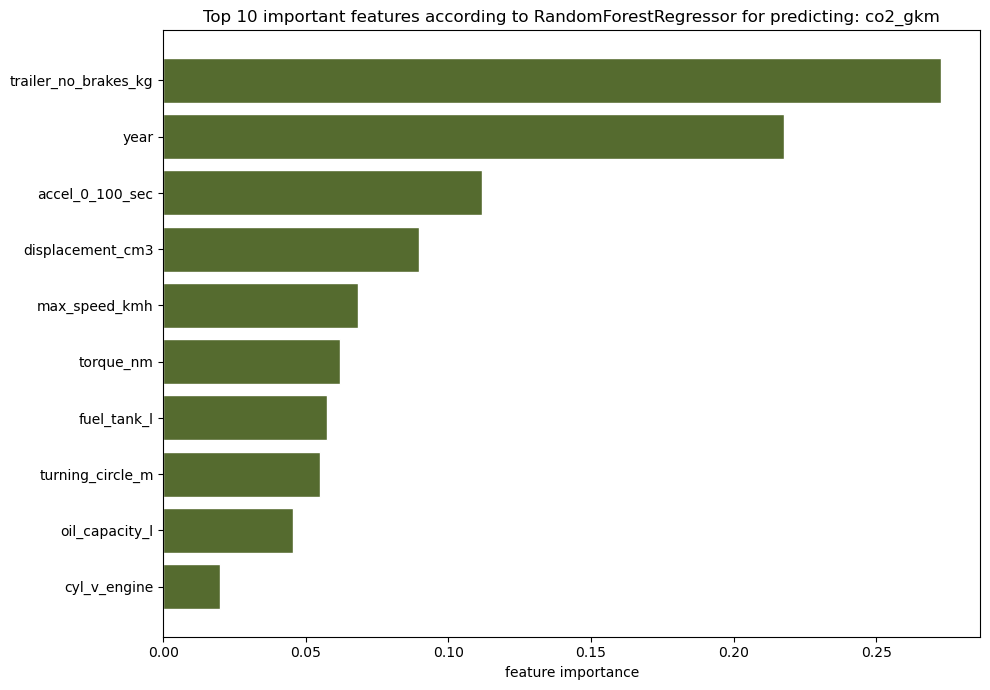


Results predicting: co2_gkm
   RMSE : 37.4
   MAE  : 15.0
   R²   : 0.8121


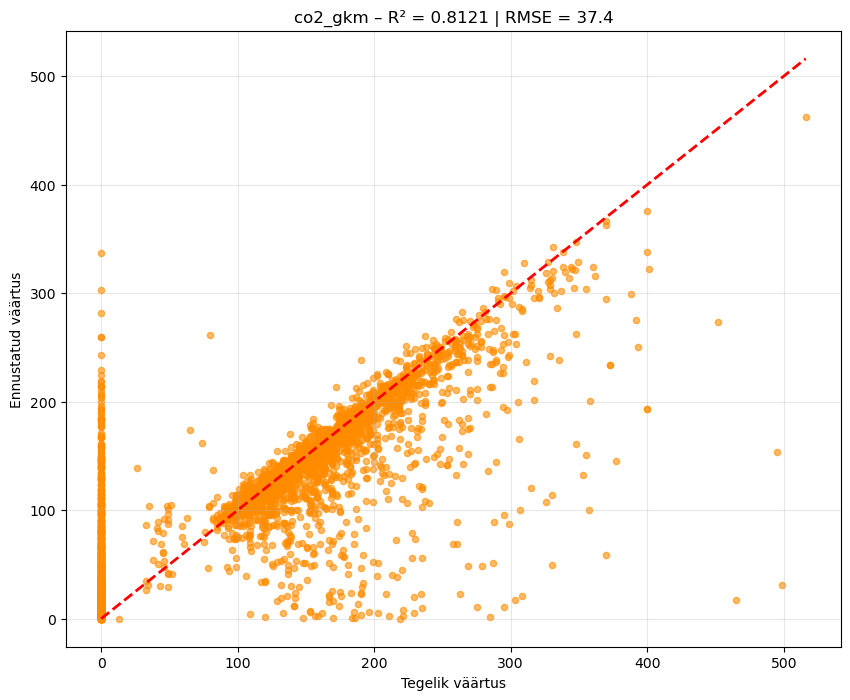

Target contains 22,839 NaNs → filling with zeros

Ffeature selection – choosing 10 best features
   → Chose 10 features (starting from the most important)
Using 10 features | y shape: (37695, 1)
→ XGBRegressor

Results: co2_gkm
   RMSE : 44.20
   MAE  : 19.85
   R²   : 0.7375


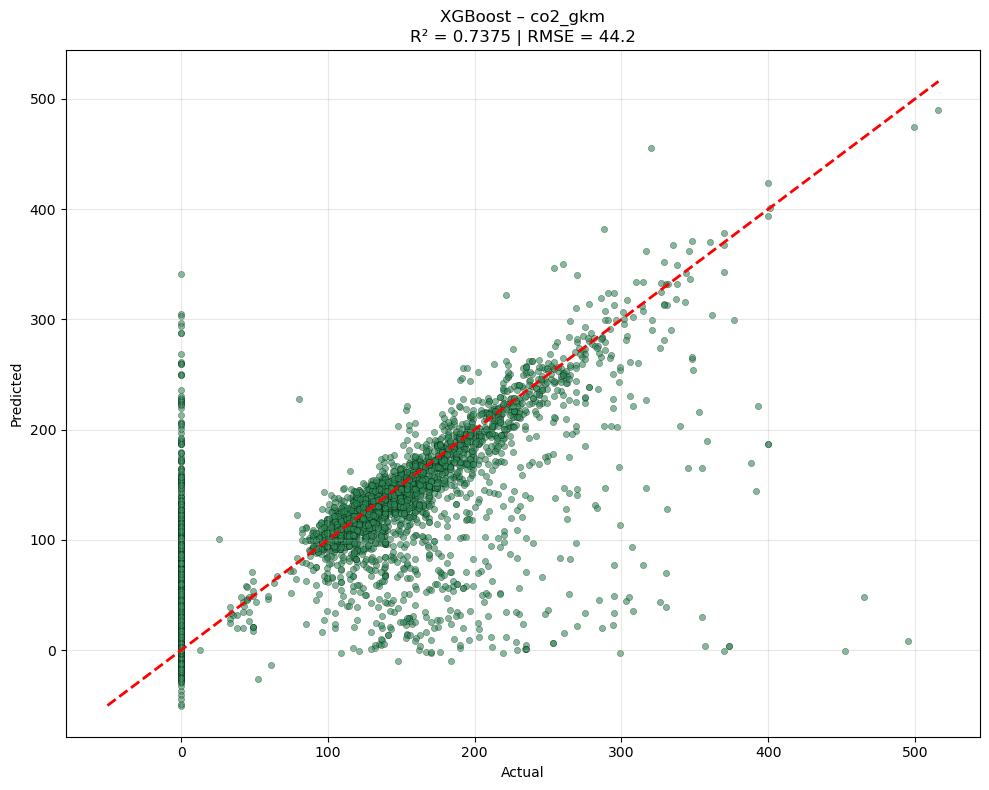

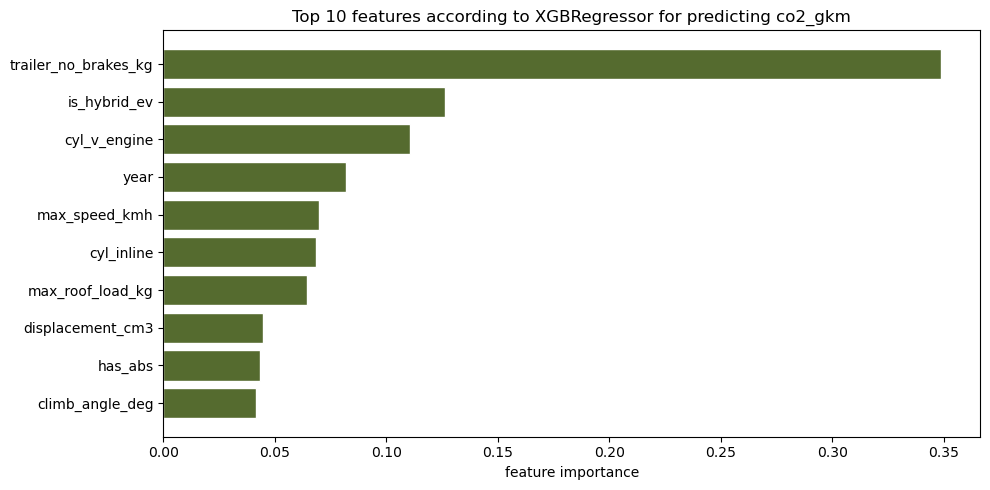

In [33]:
# results (for the poster):
# plot names and axes need to be modified for every prediction

# 1. CO2 esmission (g/km)
leakage = [
    'co2_gkm',
    'fuel_avg_l100', 'fuel_combined_l100', 'fuel_urban_l100', 'fuel_extra_urban_l100km',
    'wtop_kg_per_hp'
]
model1_1 = predict_attribute2(df, 'co2_gkm', leakage)
model1_2 = predict_xgboost(df, 'co2_gkm', leakage)

Removing 71 leaking columns
Missing values are filled with zeros

Choosing 10 best features

Training the final model... (regression)


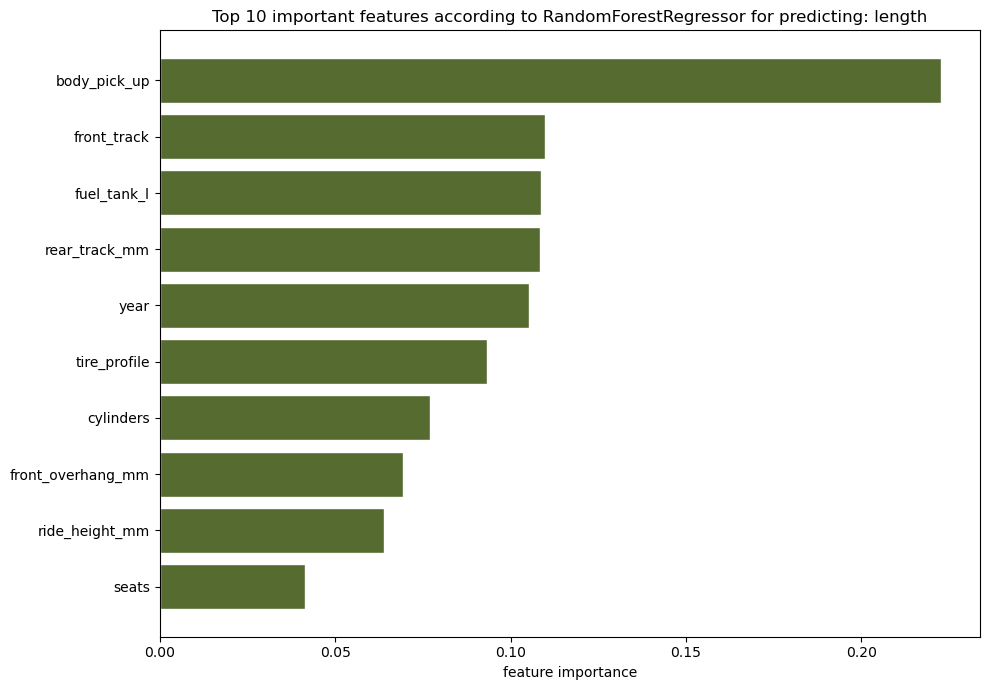


Results predicting: length
   RMSE : 2284017.2
   MAE  : 233223.6
   R²   : 0.8745


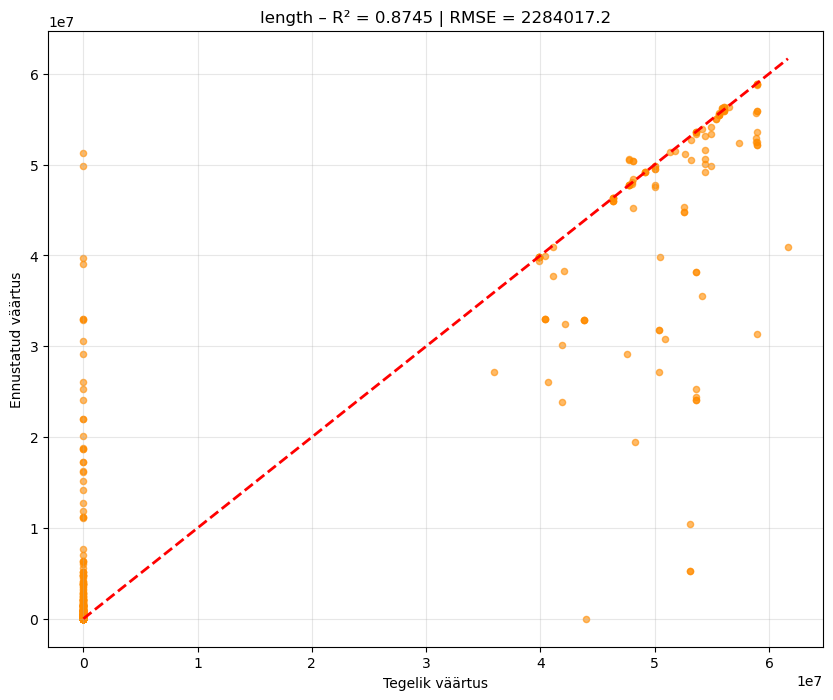

Target contains 3,171 NaNs → filling with zeros

Ffeature selection – choosing 10 best features
   → Chose 10 features (starting from the most important)
Using 10 features | y shape: (37695, 1)
→ XGBRegressor

Results: length
   RMSE : 3269465.55
   MAE  : 458965.81
   R²   : 0.7429


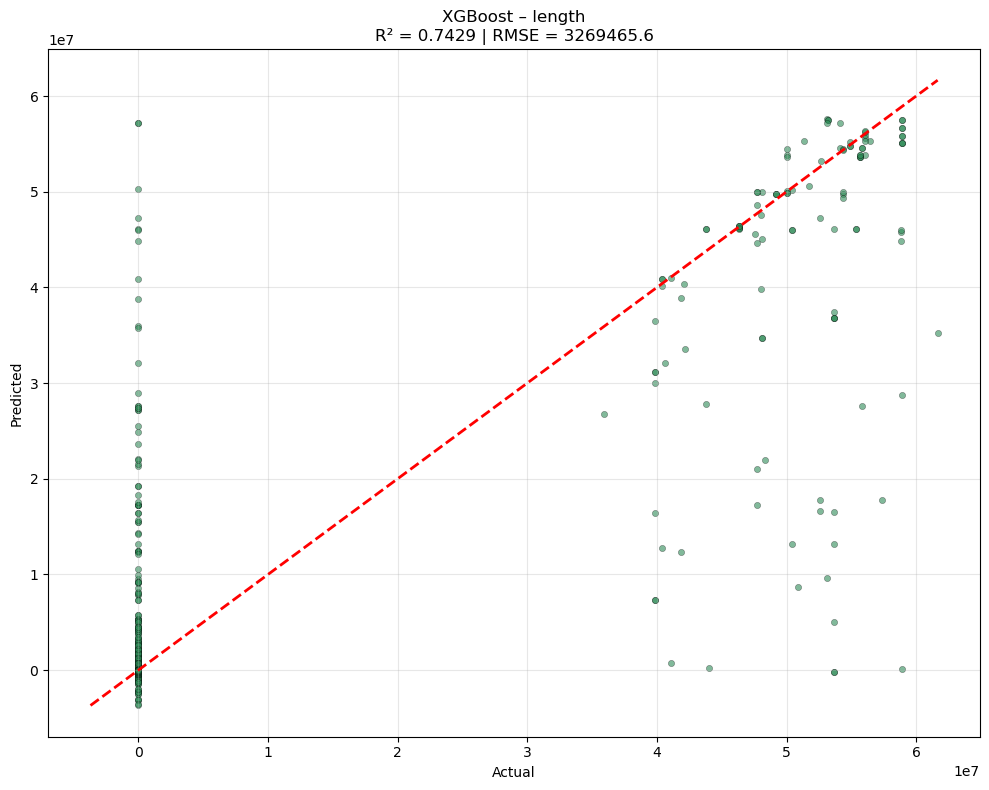

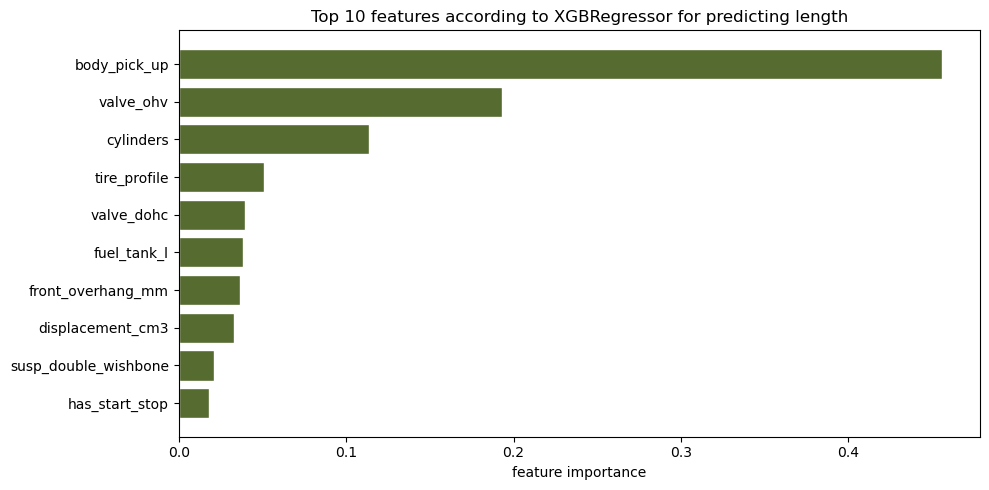

In [34]:
# 2. length
leakage = [
    'length',
    'width',
    'height',
    'wheelbase_mm',
    'kerb_weight_kg', # kaal on tihedalt seotud mõõtmetega
    'max_weight',
    'trunk_min_l', 'trunk_max_l', 'trunk_avg_l'
]
model2_1 = predict_attribute2(df, 'length', leakage)
model2_2 = predict_xgboost(df, 'length', leakage)

One-hot group identified → removing all same group columns
Removing 71 leaking columns
Missing values are filled with zeros

Choosing 10 best features

Training the final model... (multi_label_one_model)


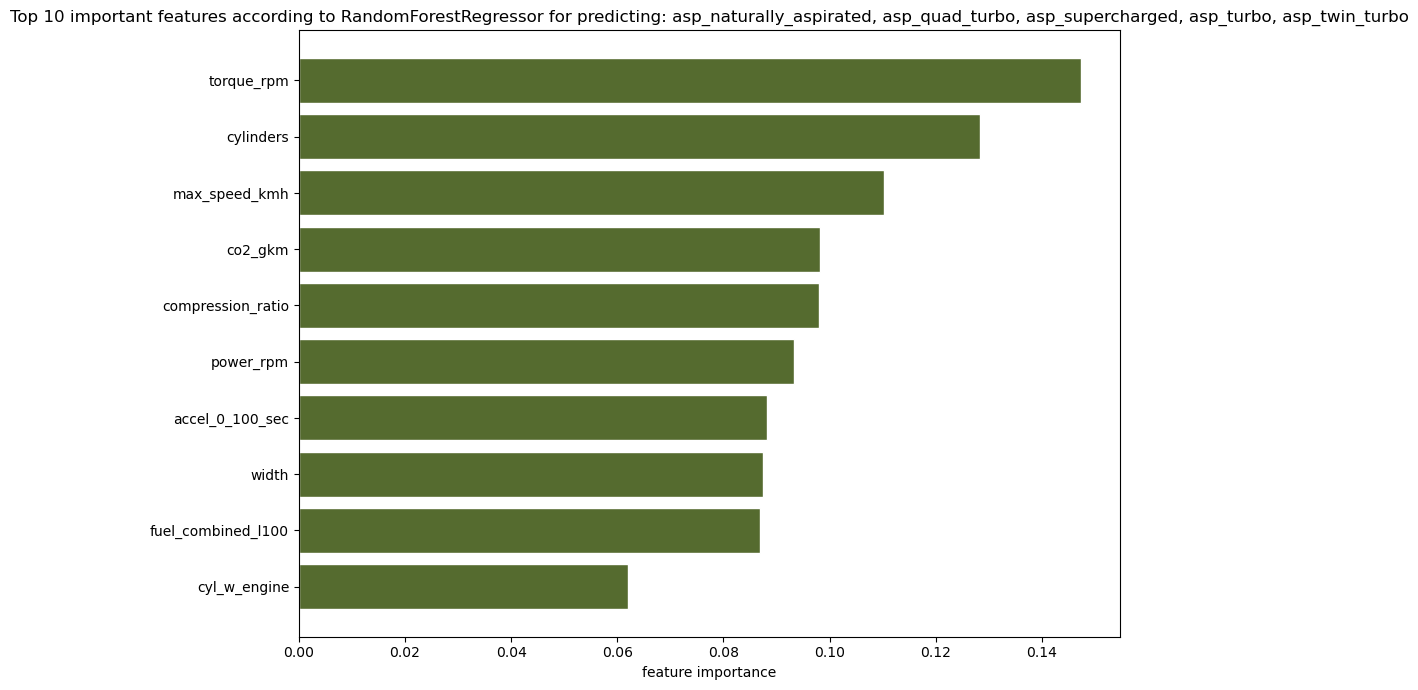


Results predicting: asp_naturally_aspirated, asp_quad_turbo, asp_supercharged, asp_turbo, asp_twin_turbo
   Accuracy   : 0.9545
   F1 (micro) : 0.9583
   F1 (macro) : 0.8533


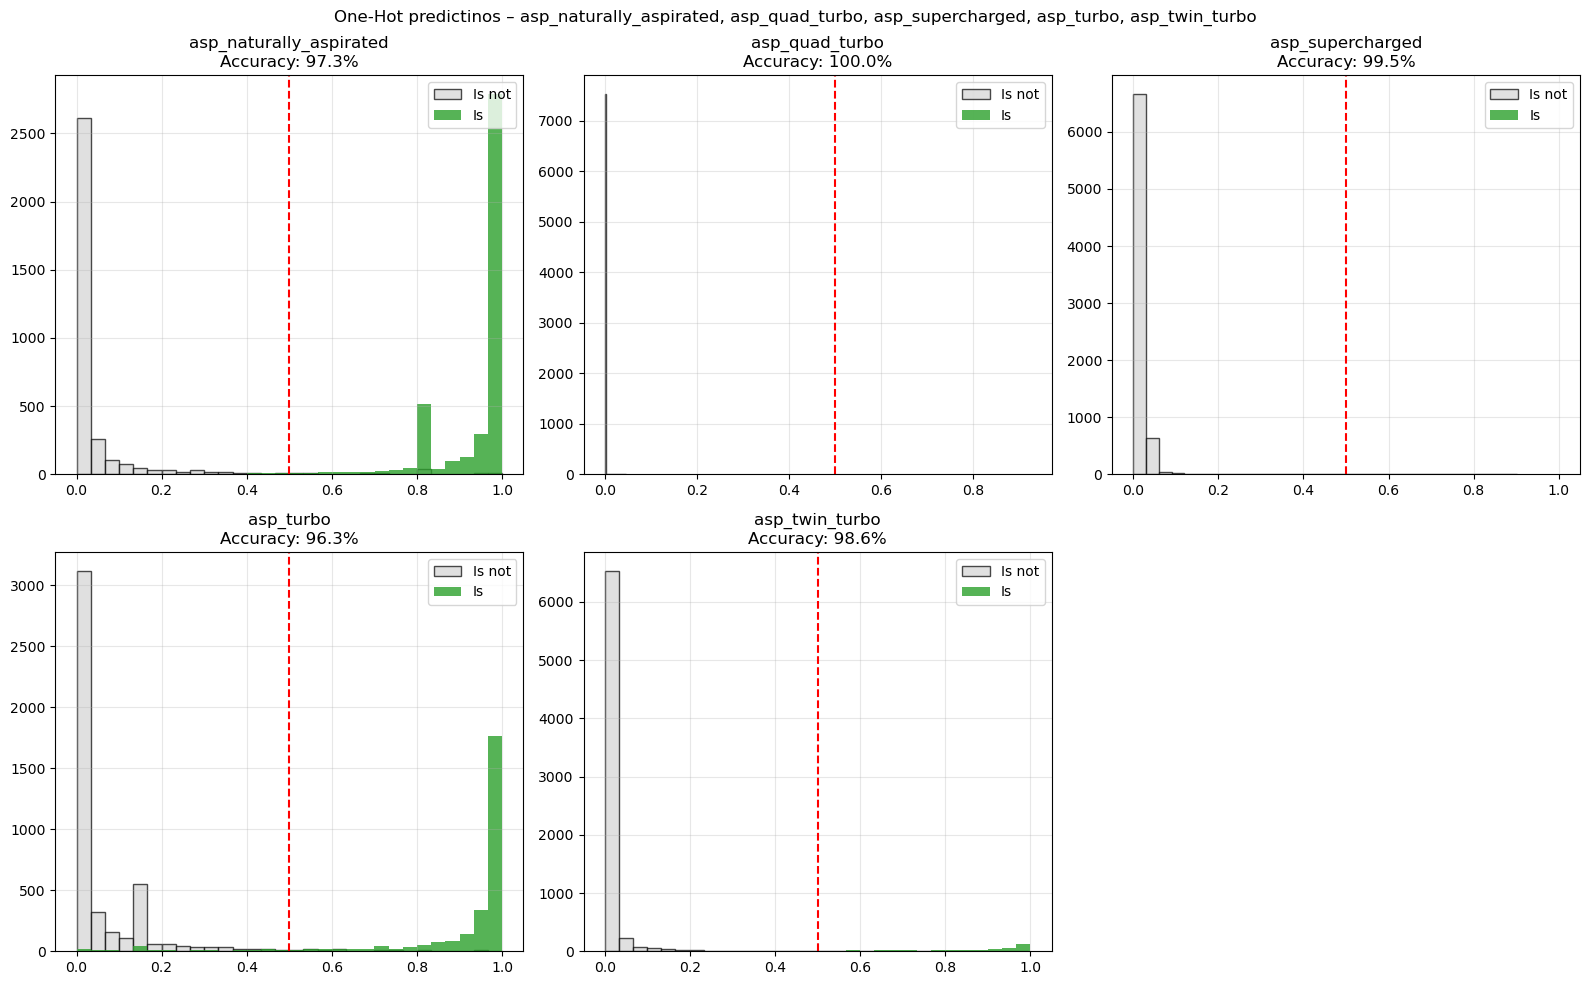


Ffeature selection – choosing 10 best features
   → Chose 10 features (starting from the most important)
Using 10 features | y shape: (37695, 5)
→ XGBClassifier (multi-label) – MultiOutputClassifier

Results: asp_naturally_aspirated + asp_quad_turbo + asp_supercharged + asp_turbo + asp_twin_turbo
   Accuracy   : 0.9057
   F1 micro   : 0.9105
   F1 macro   : 0.8431


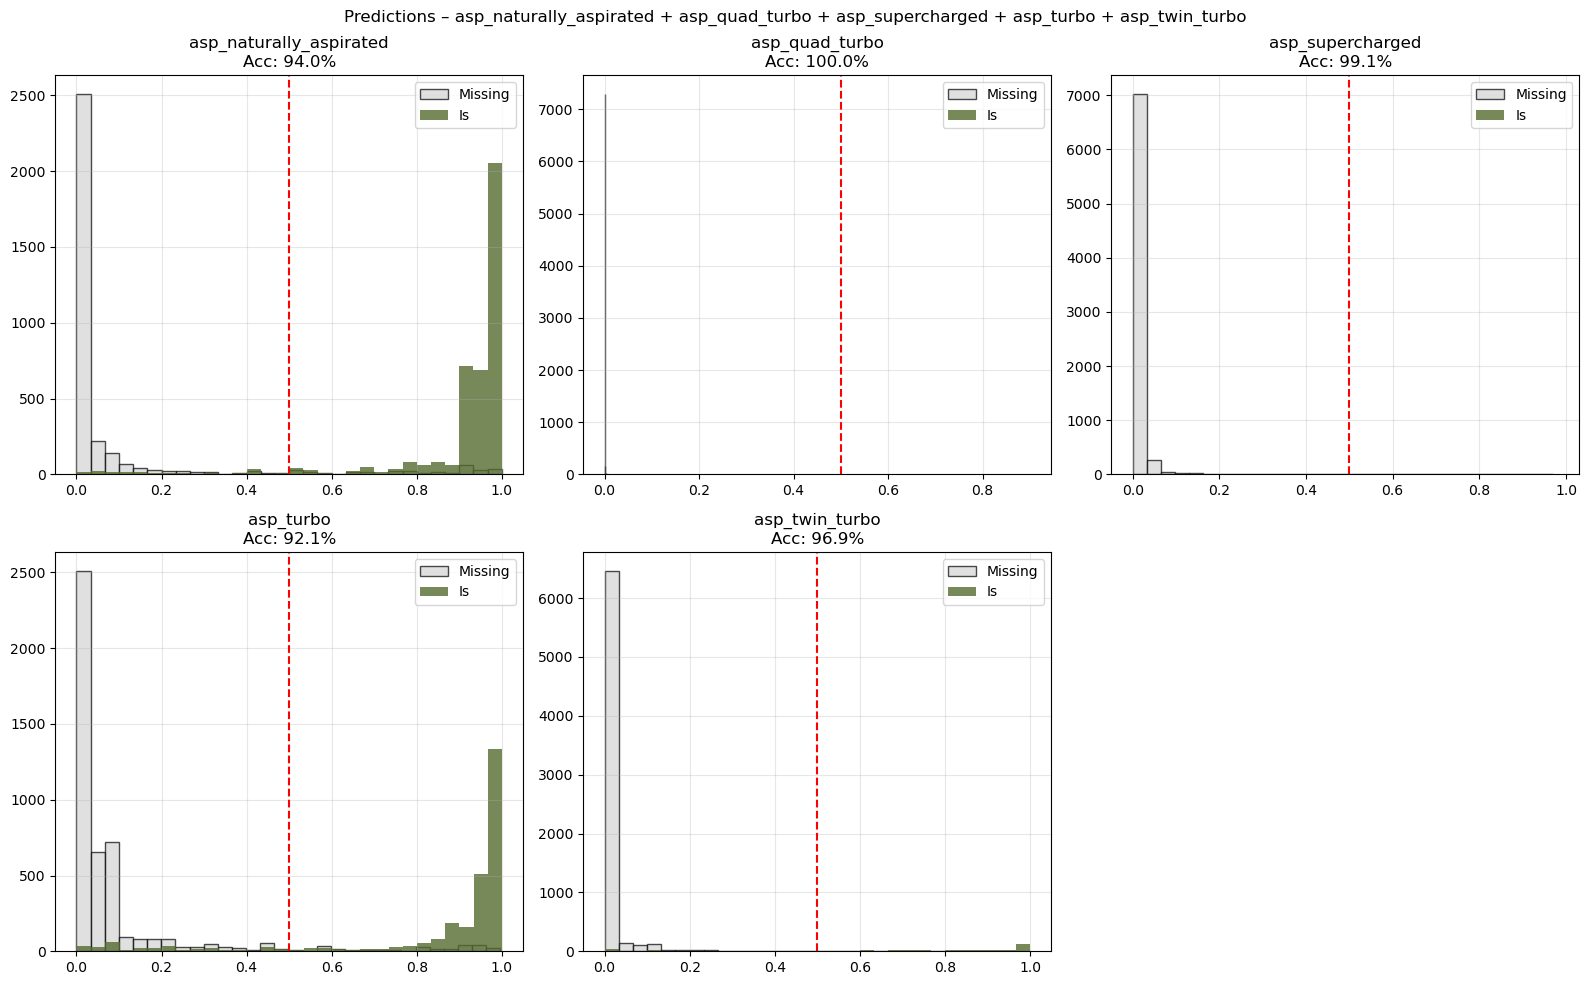

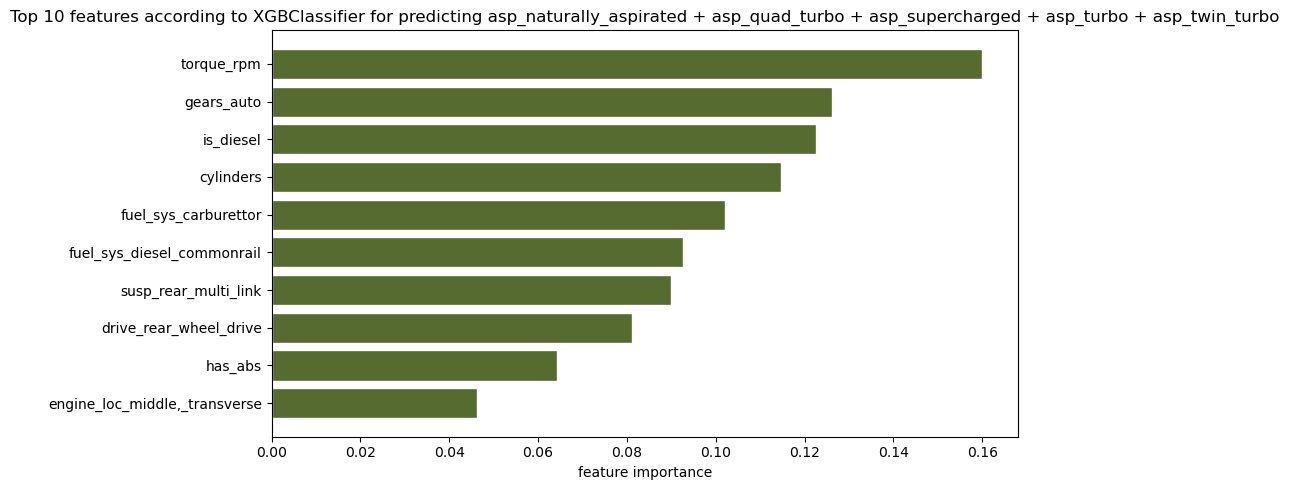

In [35]:
# 3. engine aspiration
leakage = [
    'power_kw',
    'torque_nm',
    'year',
    'displacement_cm3'
]
asp_cols = [col for col in df.columns if col.startswith('asp_')]
model3_1 = predict_attribute2(df, asp_cols, leakage)
model3_2 = predict_xgboost(df, asp_cols, leakage)

Removing 65 leaking columns
Missing values are filled with zeros

Choosing 10 best features

Training the final model... (regression)


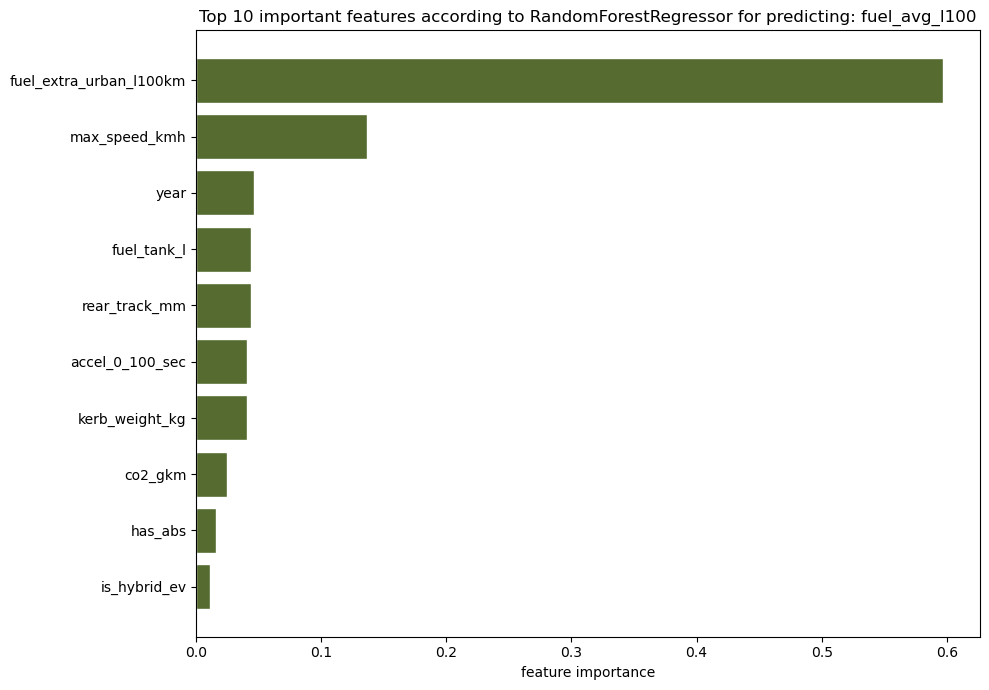


Results predicting: fuel_avg_l100
   RMSE : 1.3
   MAE  : 0.5
   R²   : 0.9058


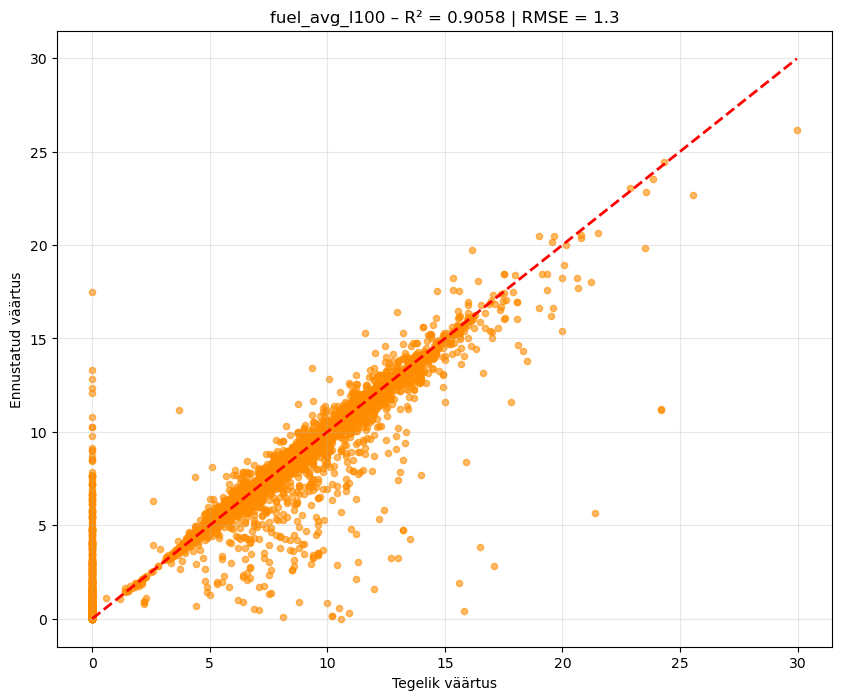

Target contains 8,097 NaNs → filling with zeros

Ffeature selection – choosing 10 best features
   → Chose 10 features (starting from the most important)
Using 10 features | y shape: (37695, 1)
→ XGBRegressor

Results: fuel_avg_l100
   RMSE : 1.59
   MAE  : 0.63
   R²   : 0.8595


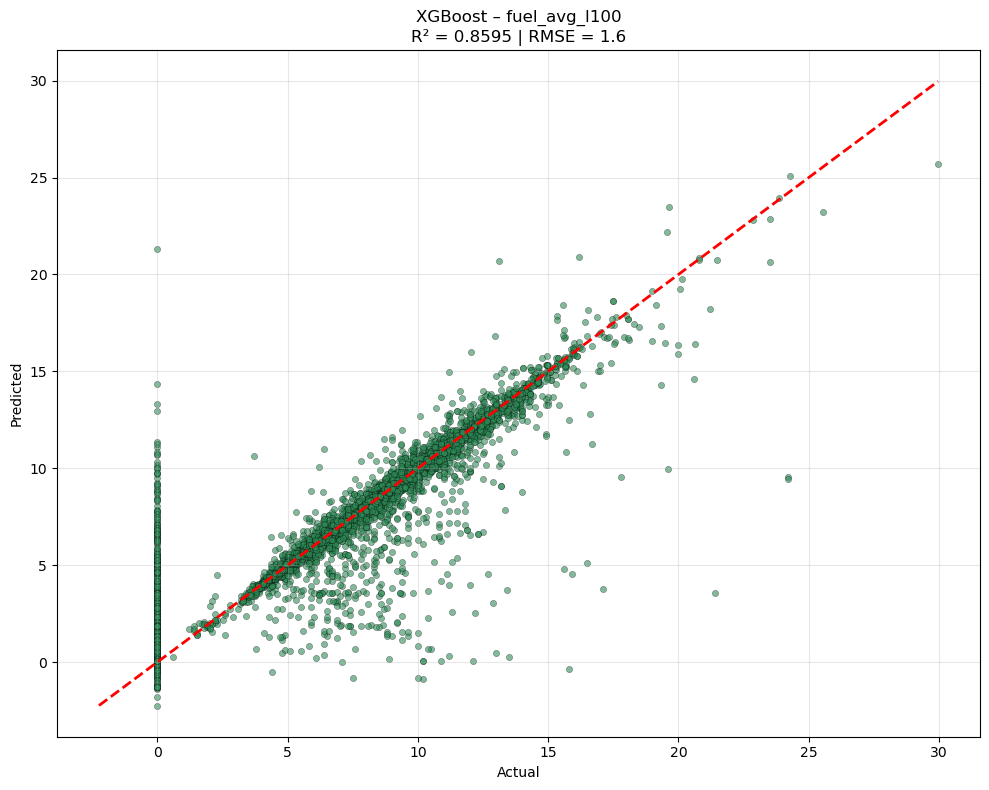

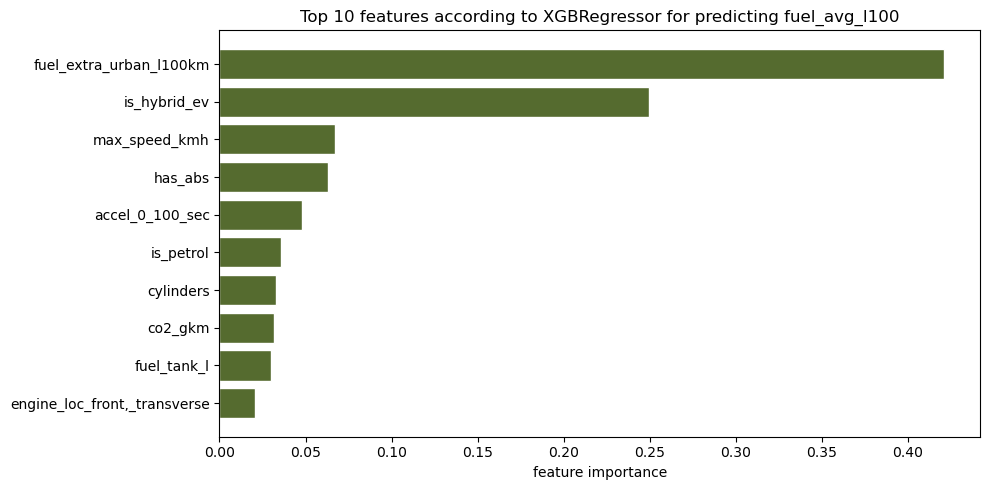

In [36]:
# 4. fuel consumption (l/100km)
leakage = [
    # Otsesed kütusekuluga seotud tulbad
    'fuel_avg_l100', 'fuel_combined_l100', 'fuel_urban_l100', 'fuel_extra_urban_l100km'
    # CO2 on peaaegu 1:1 seos kütusekuluga
    'co2_gkm',
    # Kaal/võimsus suhe samuti
    'wtop_kg_per_hp'
]
model4_1 = predict_attribute2(df, 'fuel_avg_l100', leakage)
model4_2 = predict_xgboost(df, 'fuel_avg_l100', leakage)

Removing 69 leaking columns
Missing values are filled with zeros

Choosing 10 best features

Training the final model... (regression)


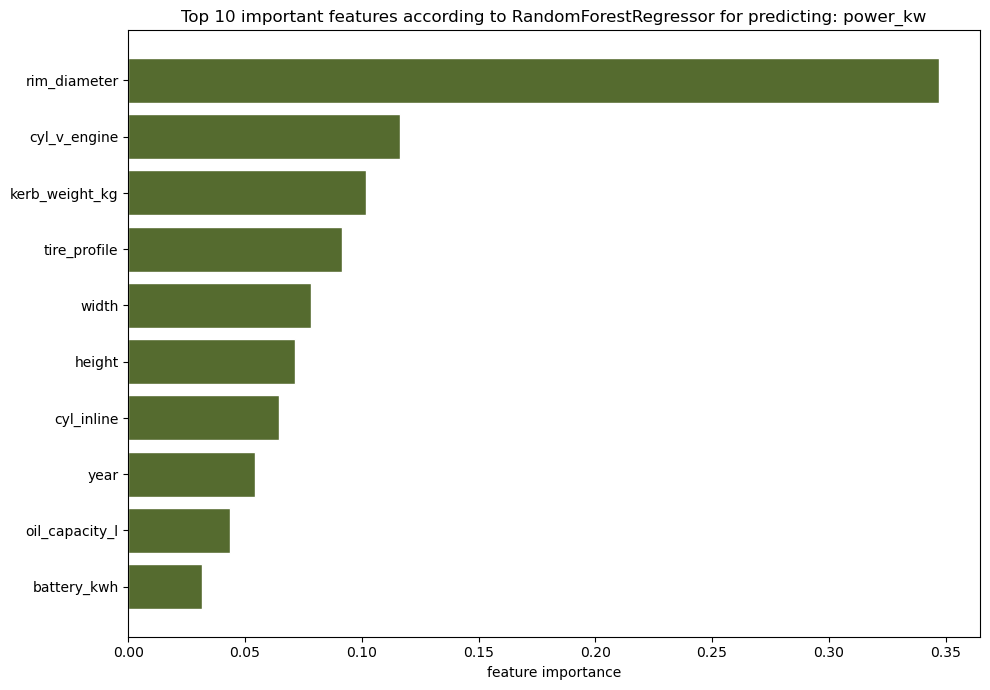


Results predicting: power_kw
   RMSE : 34.6
   MAE  : 16.2
   R²   : 0.8287


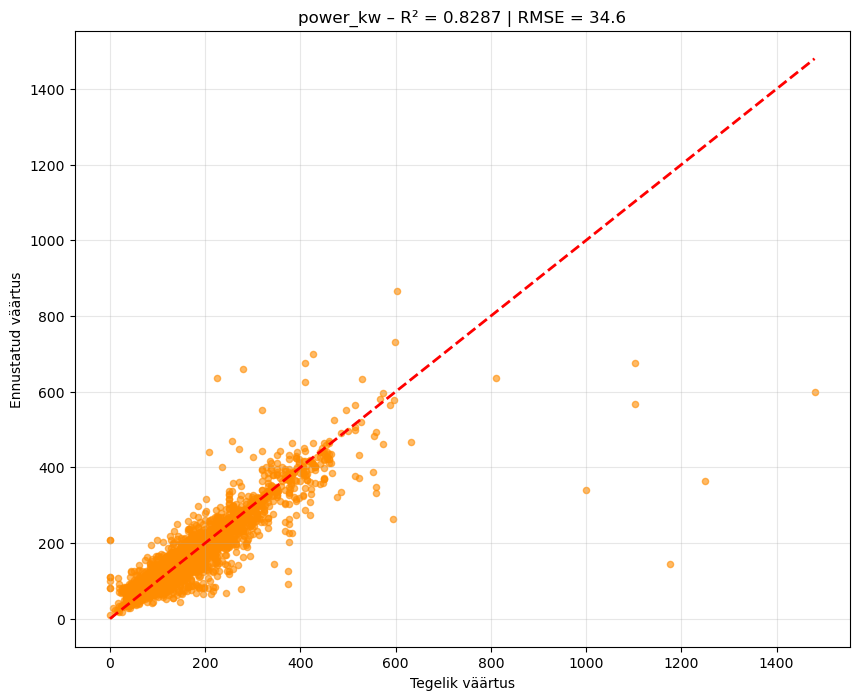

Target contains 30 NaNs → filling with zeros

Ffeature selection – choosing 10 best features
   → Chose 10 features (starting from the most important)
Using 10 features | y shape: (37695, 1)
→ XGBRegressor

Results: power_kw
   RMSE : 42.12
   MAE  : 25.06
   R²   : 0.7457


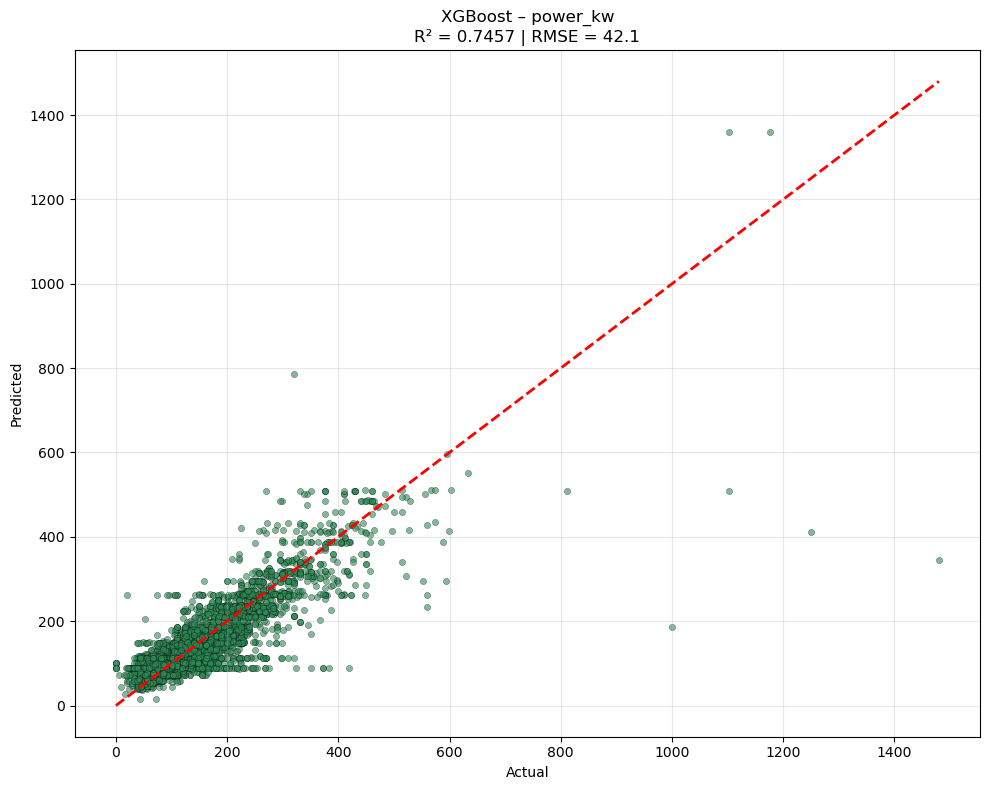

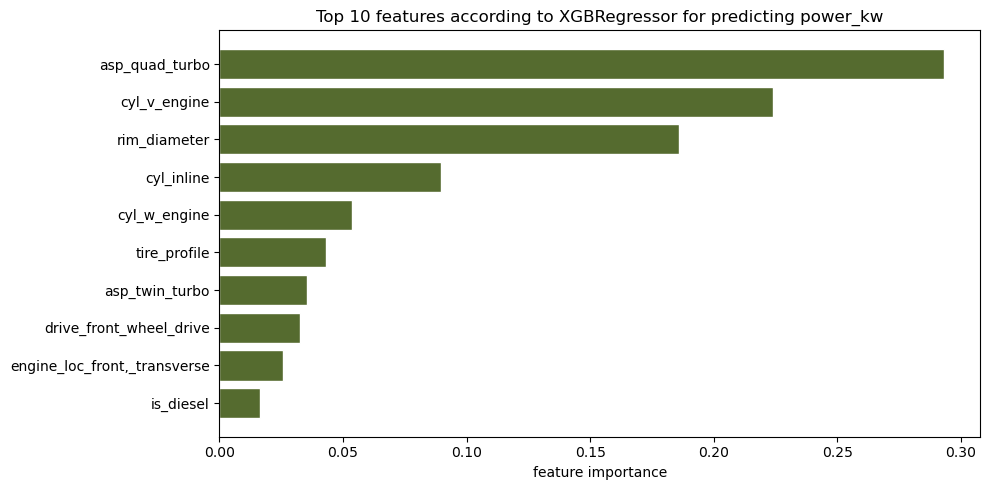

In [37]:
# 5. kw
leakage = [
    'power_kw',
    'power_rpm',
    'torque_nm',
    'displacement_cm3',
    'cylinders',
    'wtop_kg_per_hp',
    'accel_0_100_sec',
    'max_speed_kmh'
]
model5_1 = predict_attribute2(df, 'power_kw', leakage)
model5_2 = predict_xgboost(df, 'power_kw', leakage)

Removing 70 leaking columns
Missing values are filled with zeros

Choosing 10 best features

Training the final model... (regression)


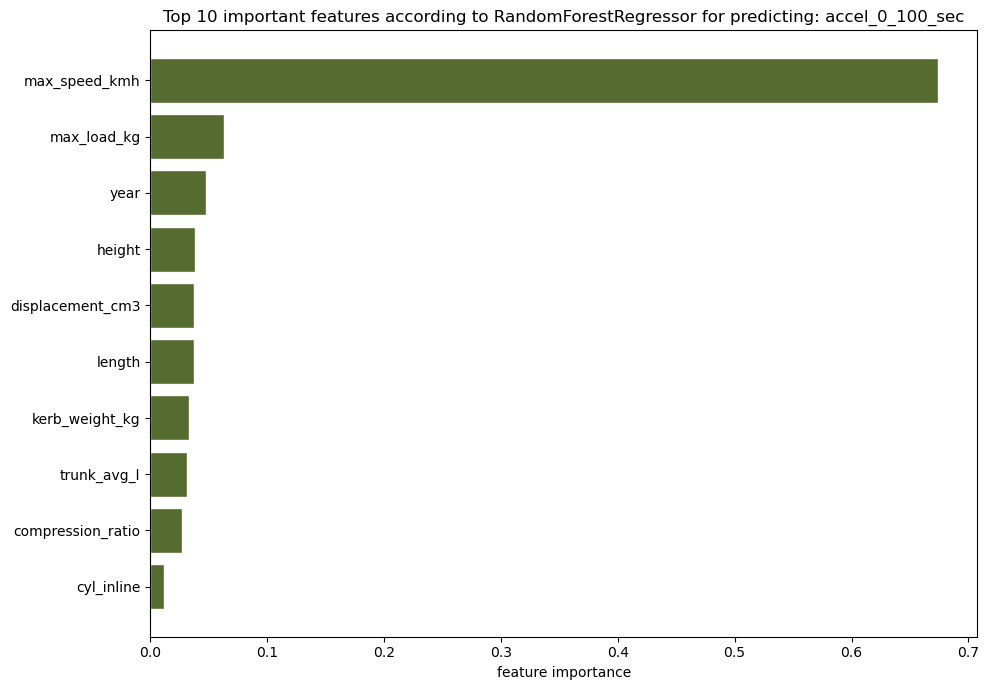


Results predicting: accel_0_100_sec
   RMSE : 1.9
   MAE  : 0.8
   R²   : 0.8652


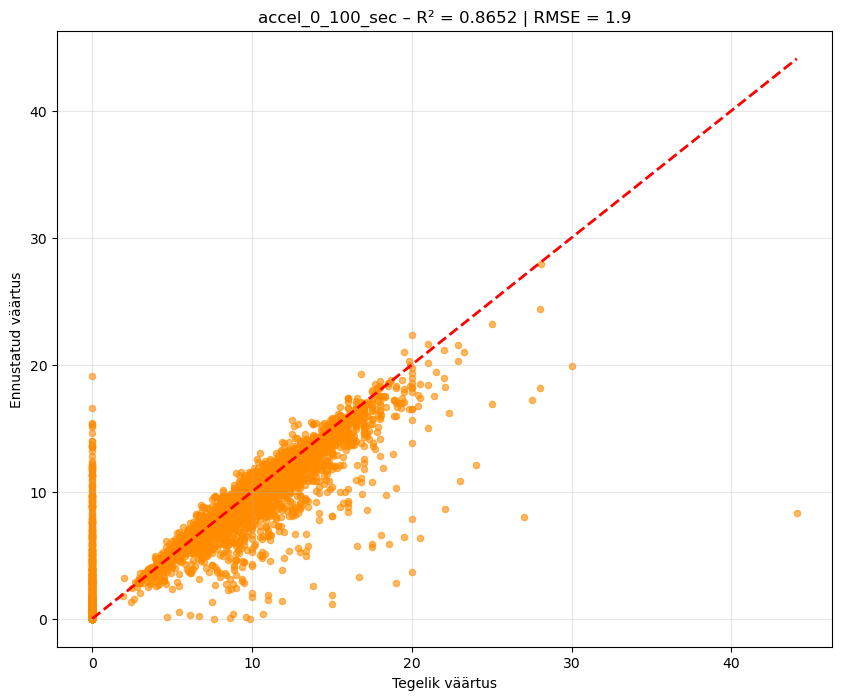

Target contains 10,805 NaNs → filling with zeros

Ffeature selection – choosing 10 best features
   → Chose 10 features (starting from the most important)
Using 10 features | y shape: (37695, 1)
→ XGBRegressor

Results: accel_0_100_sec
   RMSE : 2.61
   MAE  : 1.24
   R²   : 0.7538


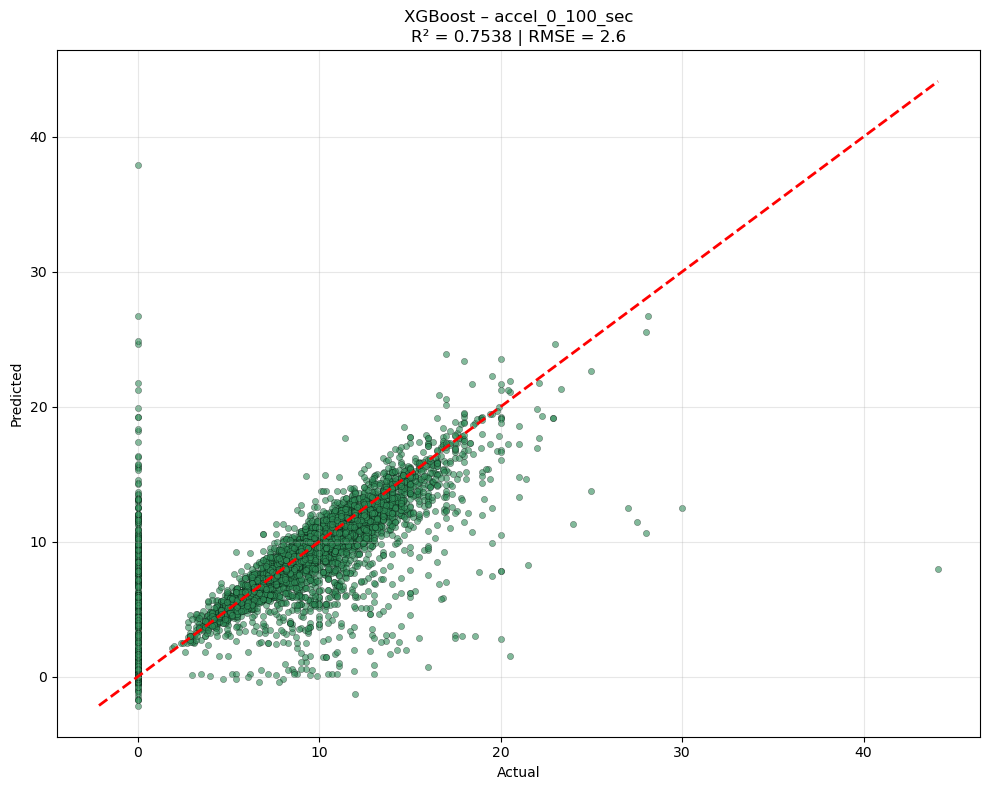

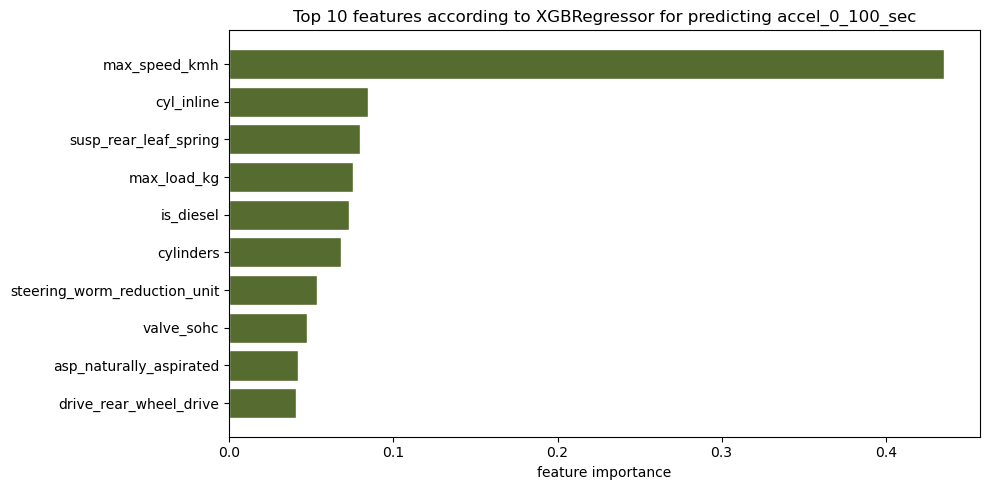

In [38]:
# 6. acceleration
leakage = [
    'accel_0_100_sec',
    
    # Kõik kütuse- ja CO2-tulbad
    'fuel_avg_l100', 'fuel_combined_l100', 'fuel_urban_l100', 'fuel_extra_urban_l100km',
    'co2_gkm',
    
    # Võimsus ja pöördemoment – need on kiirenduse peamised äraandjad
    'power_kw',
    'torque_nm',
    
    # wtop on võimsuse ja kaalu suhe – otsene kiirenduse määraja
    'wtop_kg_per_hp'
]
model6_1 = predict_attribute2(df, 'accel_0_100_sec', leakage)
model6_2 = predict_xgboost(df, 'accel_0_100_sec', leakage)

Removing 67 leaking columns
Missing values are filled with zeros

Choosing 10 best features

Training the final model... (regression)


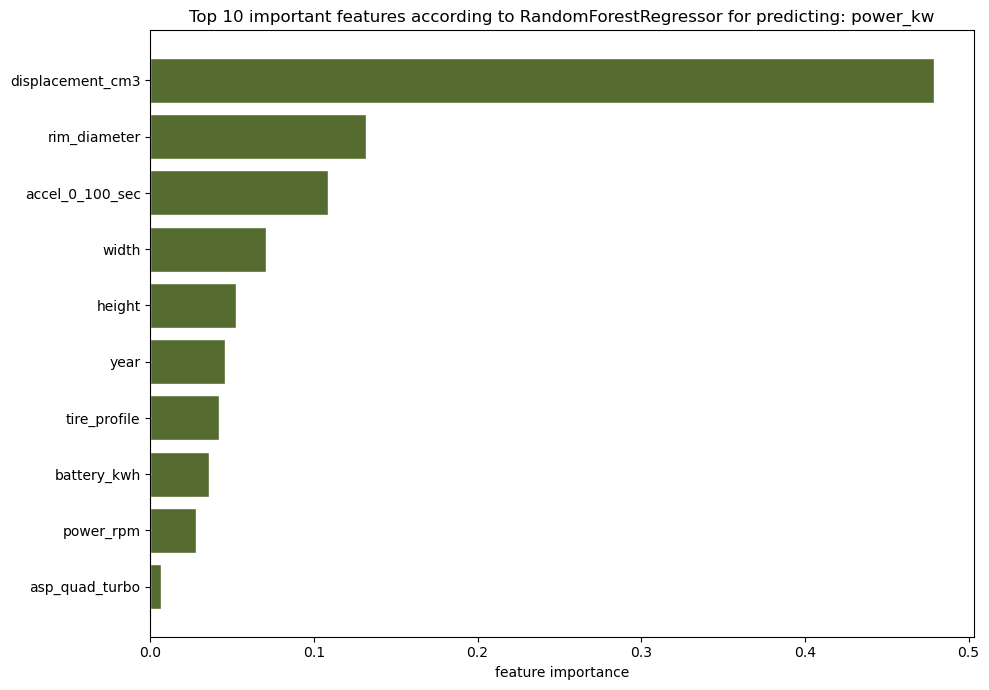


Results predicting: power_kw
   RMSE : 23.7
   MAE  : 8.1
   R²   : 0.9198


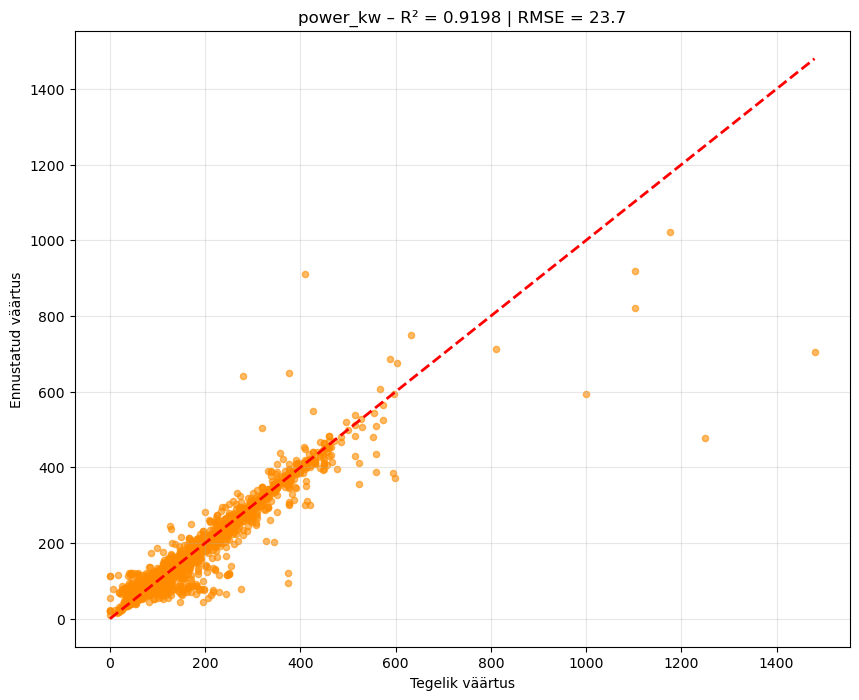

Target contains 30 NaNs → filling with zeros

Ffeature selection – choosing 10 best features
   → Chose 10 features (starting from the most important)
Using 10 features | y shape: (37695, 1)
→ XGBRegressor

Results: power_kw
   RMSE : 24.29
   MAE  : 10.50
   R²   : 0.9154


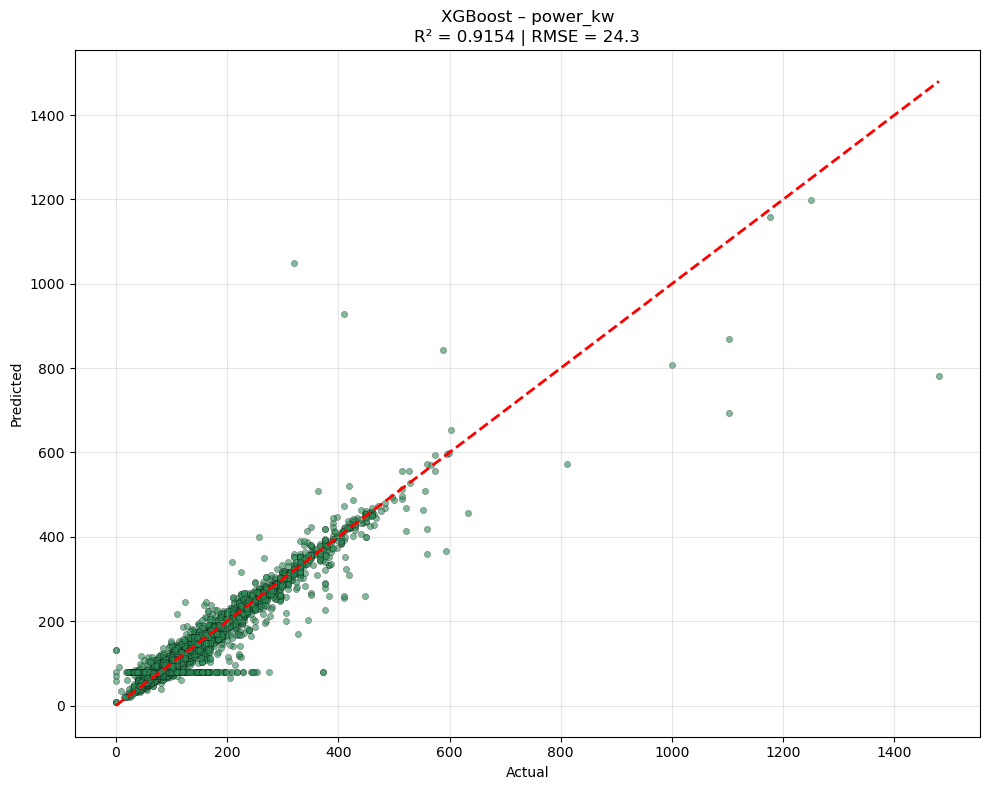

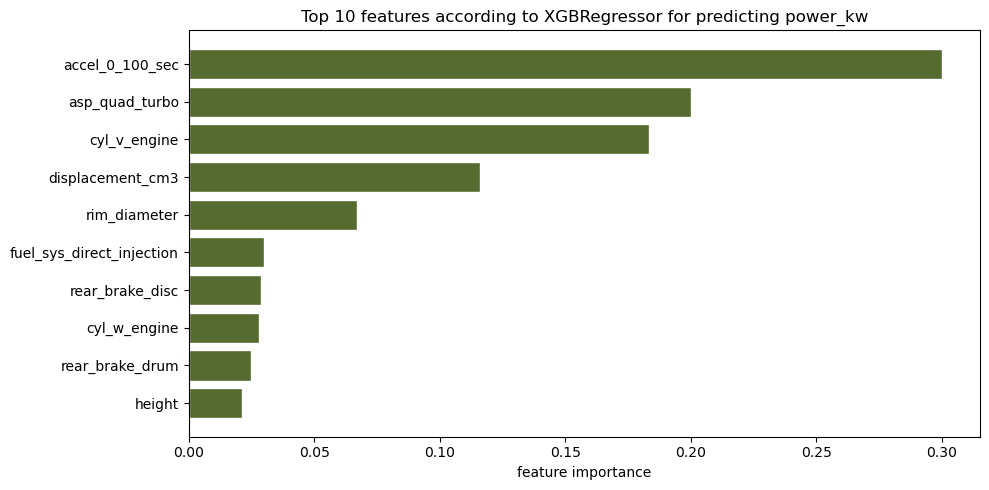

In [39]:
# 7. max speed
leakage = [
    'max_speed_kmh',
    'power_hp',
    'torque_nm',
    'wtop_kg_per_hp',
    'drag_cd',  # aerodünaamika mõjutab otseselt
    'cylinders'
]
model7_1 = predict_attribute2(df, 'power_kw', leakage)
model7_2 = predict_xgboost(df, 'power_kw', leakage)

Removing 67 leaking columns
Missing values are filled with zeros

Choosing 10 best features

Training the final model... (regression)


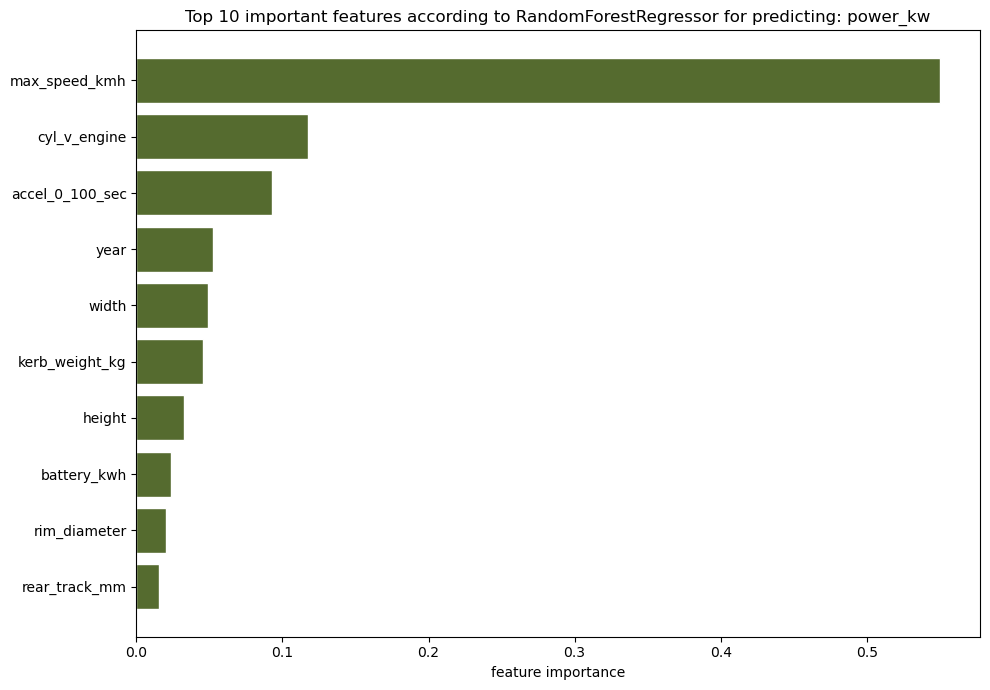


Results predicting: power_kw
   RMSE : 22.9
   MAE  : 10.4
   R²   : 0.9246


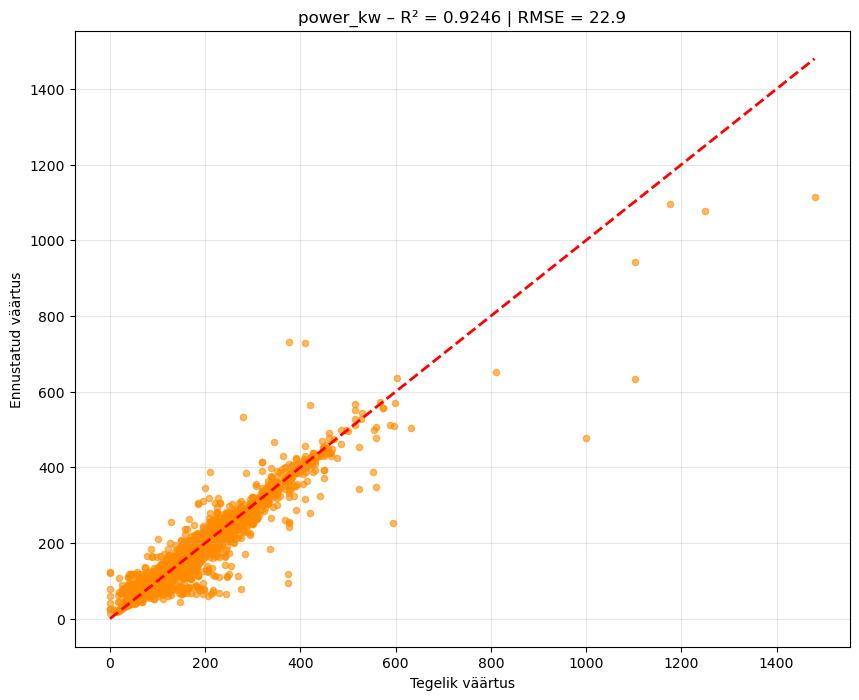

Target contains 30 NaNs → filling with zeros

Ffeature selection – choosing 10 best features
   → Chose 10 features (starting from the most important)
Using 10 features | y shape: (37695, 1)
→ XGBRegressor

Results: power_kw
   RMSE : 26.16
   MAE  : 11.41
   R²   : 0.9019


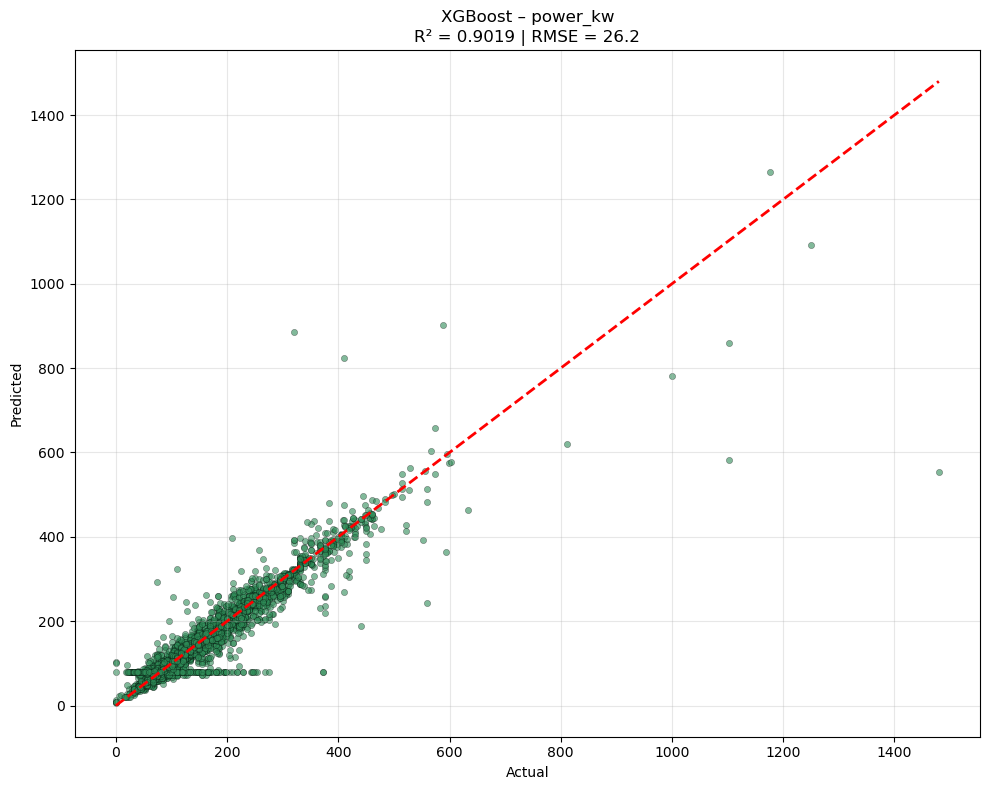

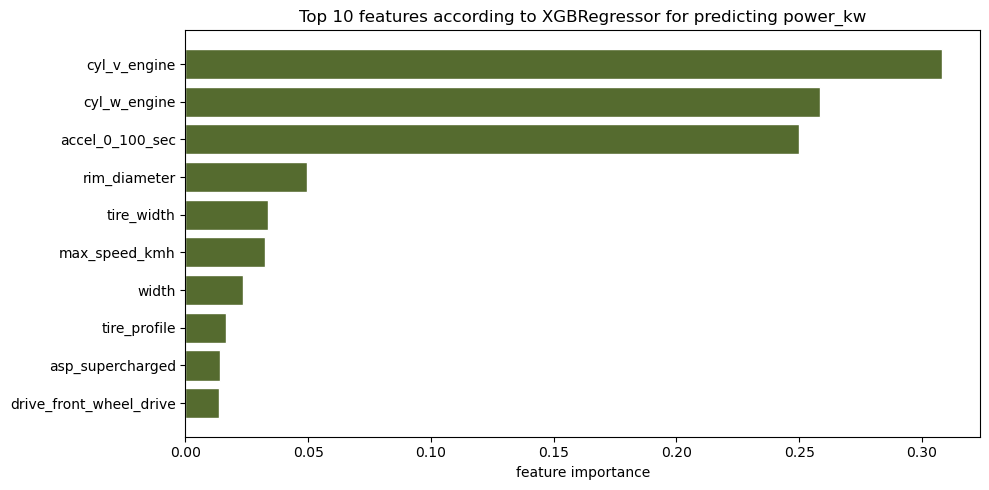

In [40]:
# 8. torque
leakage = [
    'torque_nm',
    'torque_rpm',
    'power_kw',
    'displacement_cm3',
    'cylinders',
    'wtop_kg_per_hp'
]
model8_1 = predict_attribute2(df, 'power_kw', leakage)
model8_2 = predict_xgboost(df, 'power_kw', leakage)

Removing 66 leaking columns
Missing values are filled with zeros

Choosing 10 best features

Training the final model... (regression)


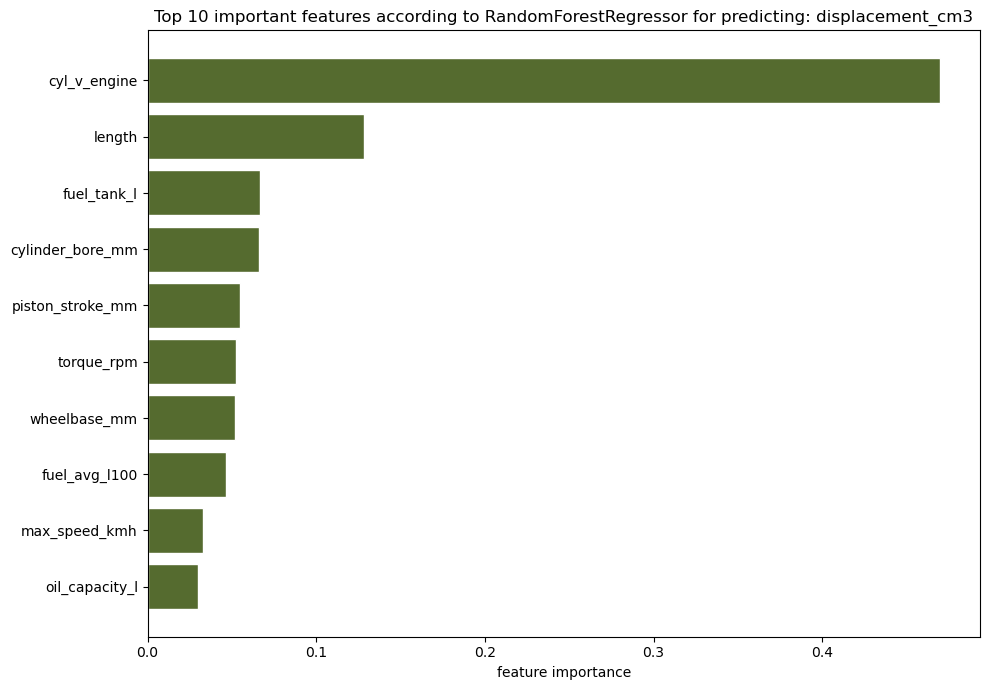


Results predicting: displacement_cm3
   RMSE : 280.2
   MAE  : 88.1
   R²   : 0.9554


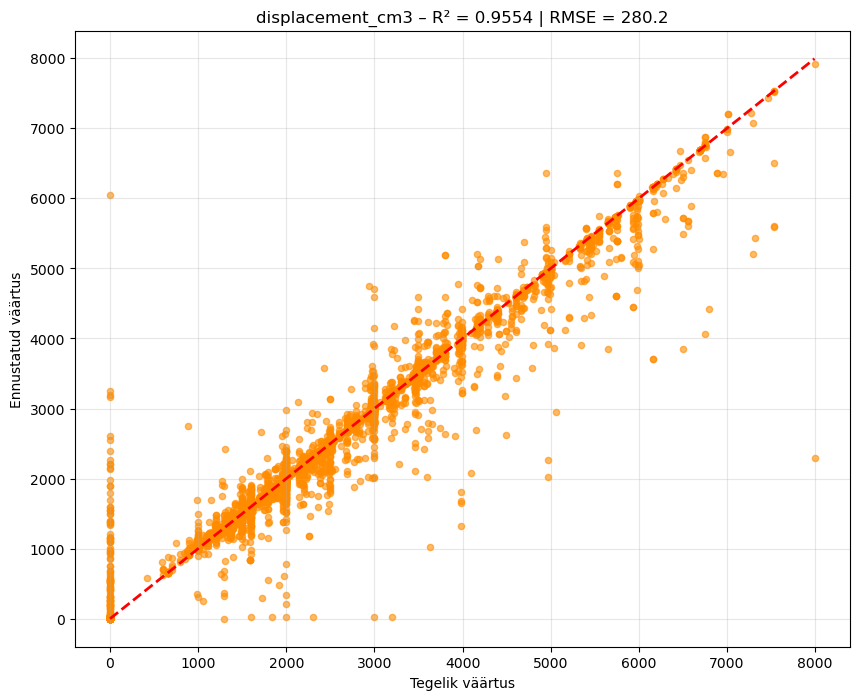

Target contains 3,532 NaNs → filling with zeros

Ffeature selection – choosing 10 best features
   → Chose 10 features (starting from the most important)
Using 10 features | y shape: (37695, 1)
→ XGBRegressor

Results: displacement_cm3
   RMSE : 352.09
   MAE  : 187.16
   R²   : 0.9295


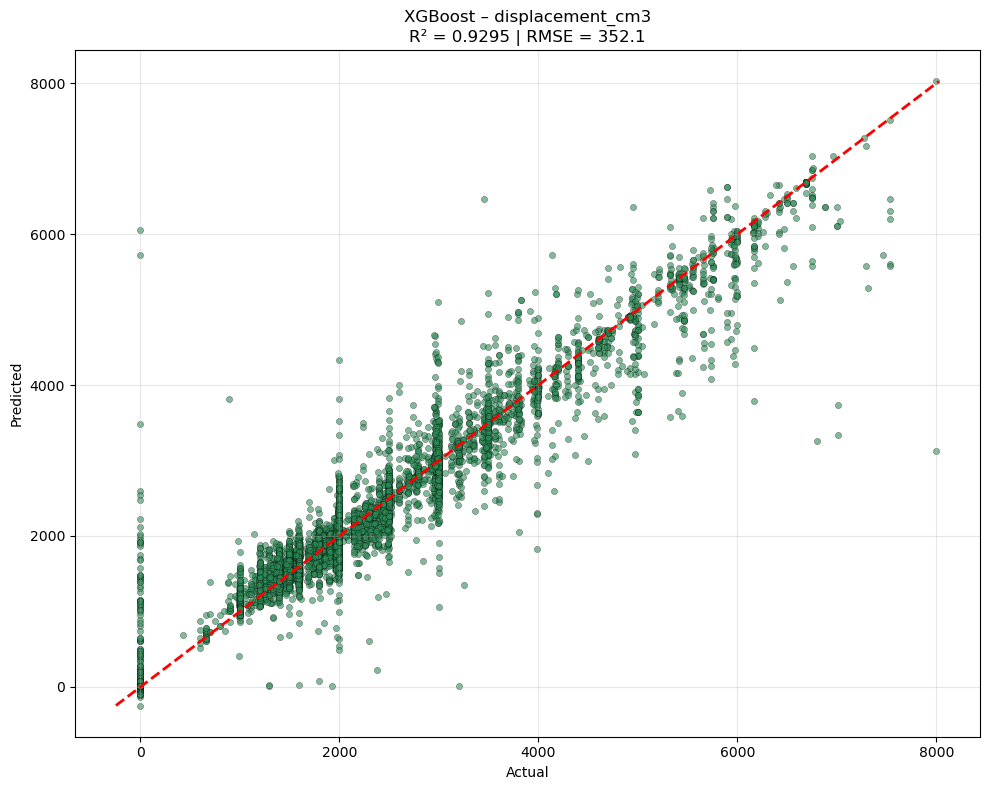

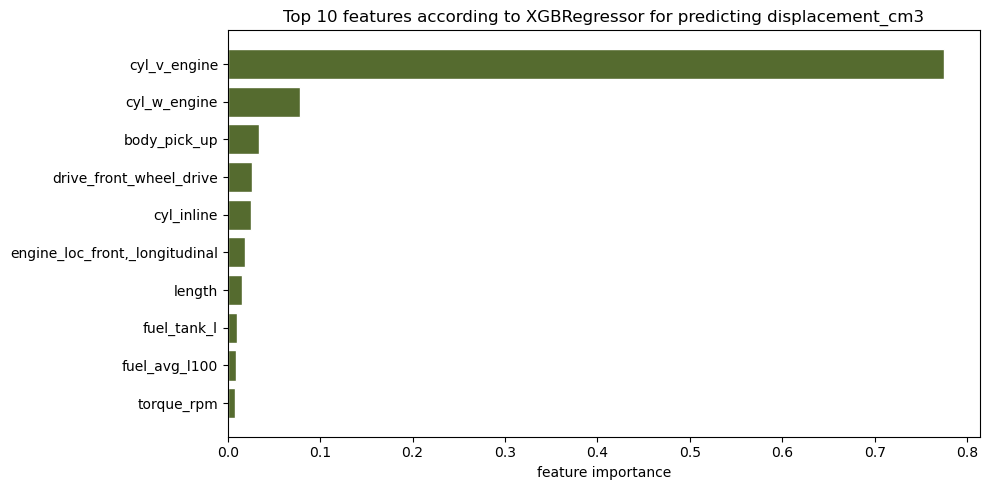

In [41]:
# 9. displacement
leakage = [
    'displacement_cm3',
    'power_kw',
    'torque_nm',
    'cylinders',
    'wtop_kg_per_hp'
]
model9_1 = predict_attribute2(df, 'displacement_cm3', leakage)
model9_2 = predict_xgboost(df, 'displacement_cm3', leakage)

One-hot group identified → removing all same group columns
Removing 75 leaking columns
Missing values are filled with zeros

Choosing 10 best features

Training the final model... (multi_label_one_model)


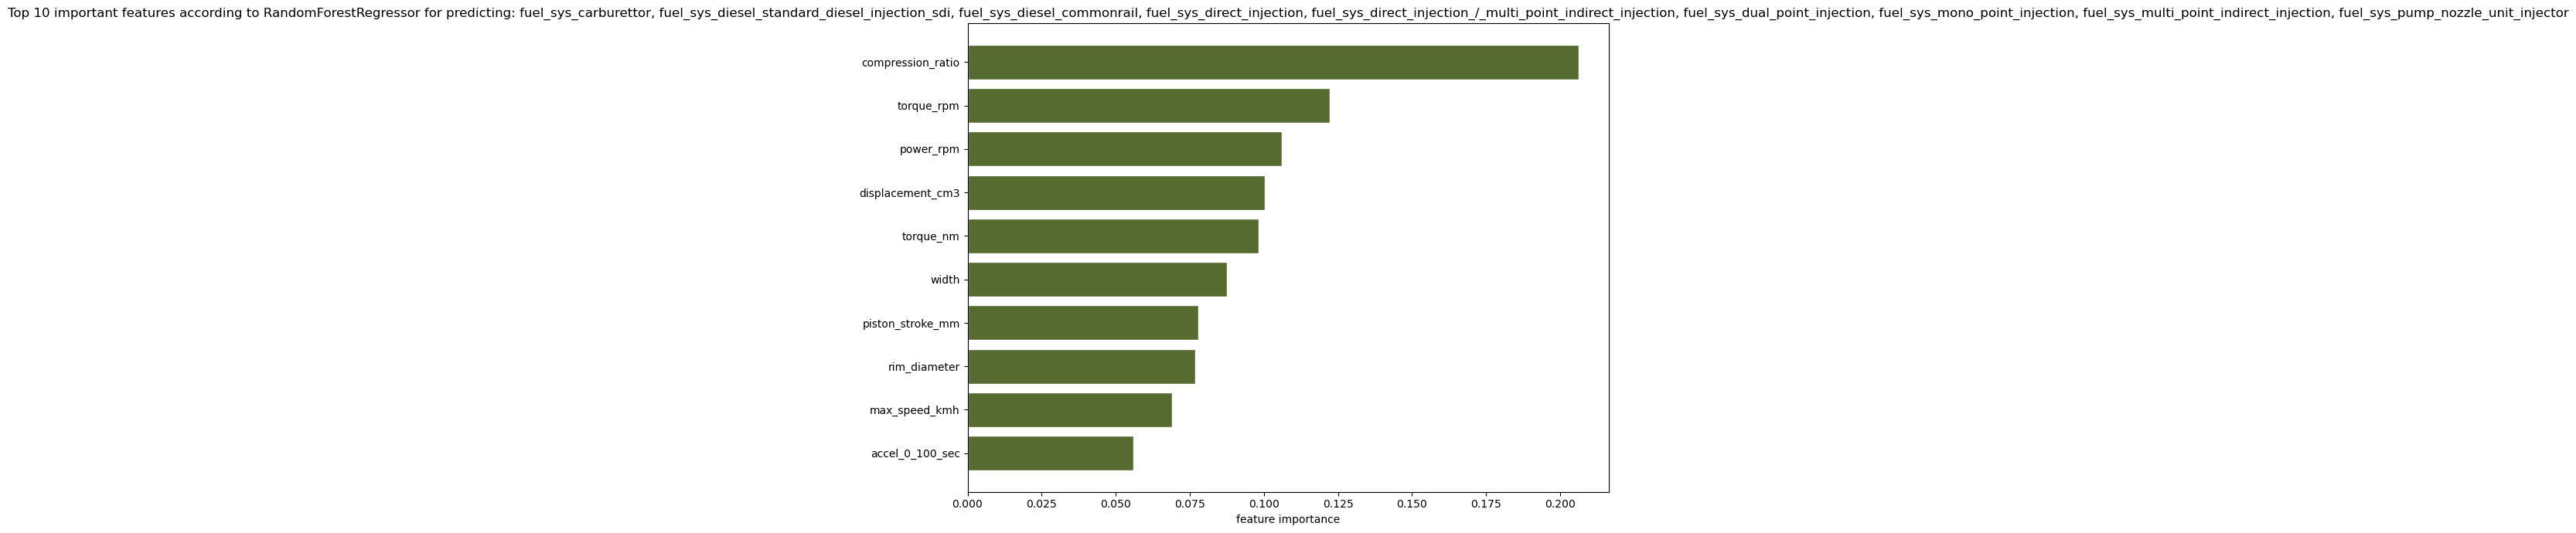


Results predicting: fuel_sys_carburettor, fuel_sys_diesel_standard_diesel_injection_sdi, fuel_sys_diesel_commonrail, fuel_sys_direct_injection, fuel_sys_direct_injection_/_multi_point_indirect_injection, fuel_sys_dual_point_injection, fuel_sys_mono_point_injection, fuel_sys_multi_point_indirect_injection, fuel_sys_pump_nozzle_unit_injector


C:\Users\J\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


   Accuracy   : 0.9414
   F1 (micro) : 0.9504
   F1 (macro) : 0.7309


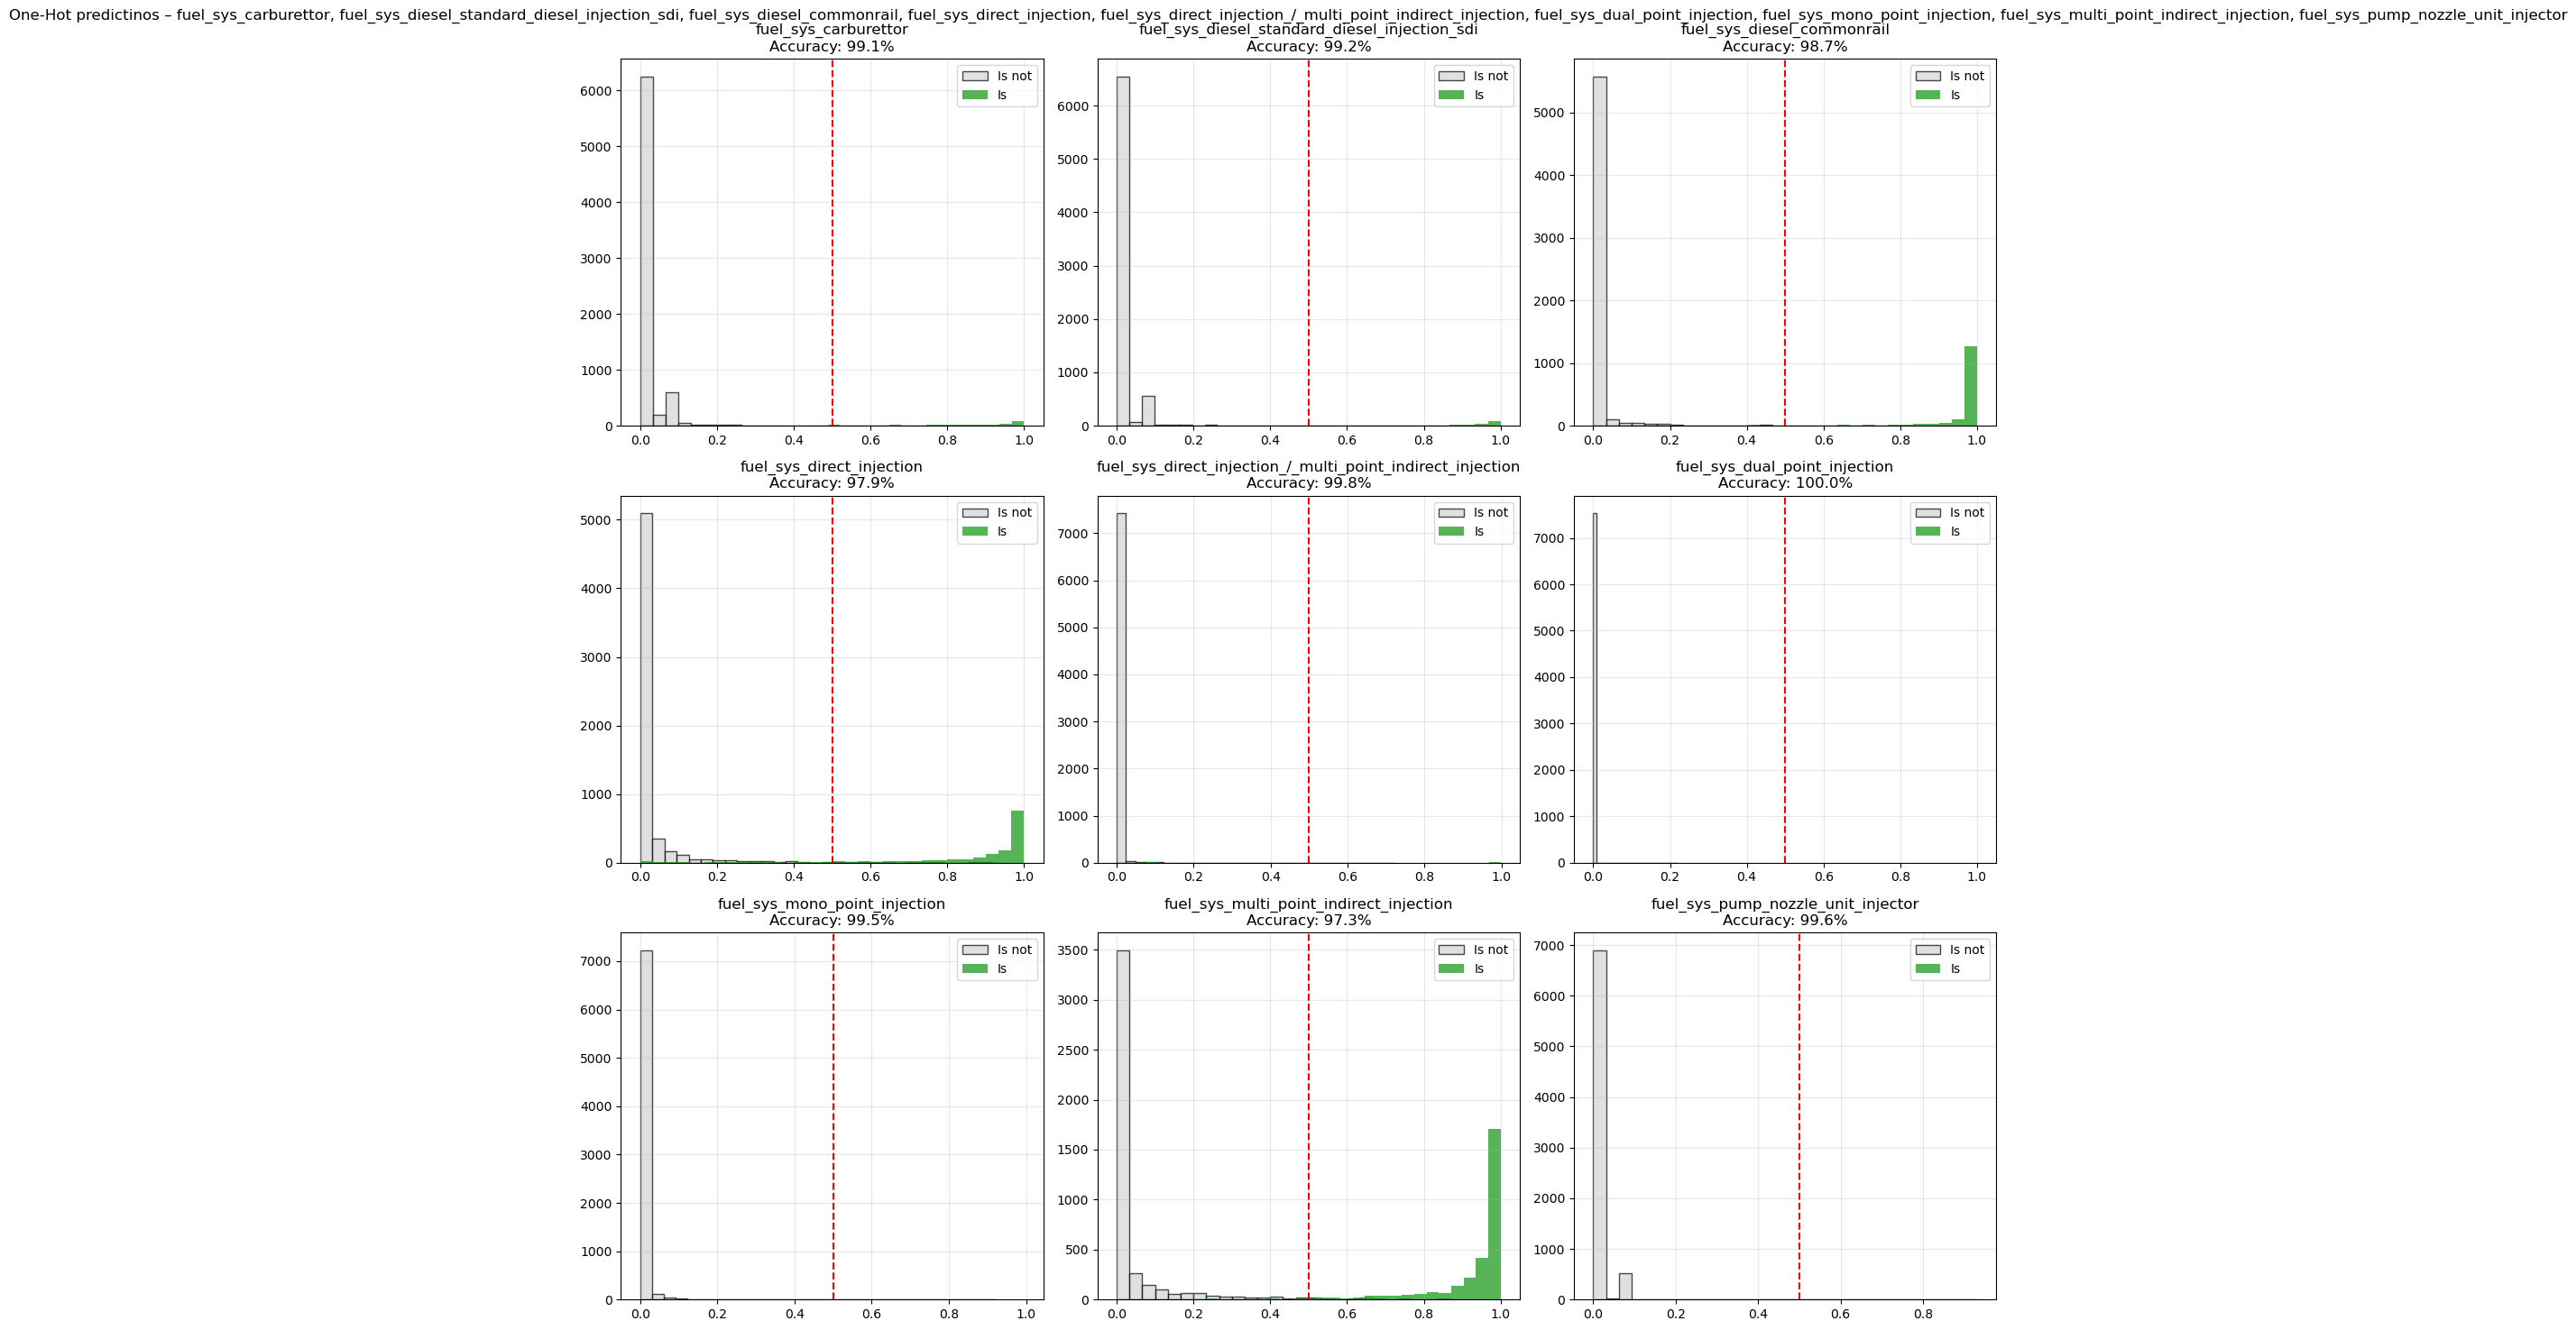


Ffeature selection – choosing 10 best features
   → Chose 10 features (starting from the most important)
Using 10 features | y shape: (37695, 9)
→ XGBClassifier (multi-label) – MultiOutputClassifier


C:\Users\J\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Results: fuel_sys_carburettor + fuel_sys_diesel_standard_diesel_injection_sdi + fuel_sys_diesel_commonrail + fuel_sys_direct_injection + fuel_sys_direct_injection_/_multi_point_indirect_injection + fuel_sys_dual_point_injection + fuel_sys_mono_point_injection + fuel_sys_multi_point_indirect_injection + fuel_sys_pump_nozzle_unit_injector
   Accuracy   : 0.9094
   F1 micro   : 0.9235
   F1 macro   : 0.6908


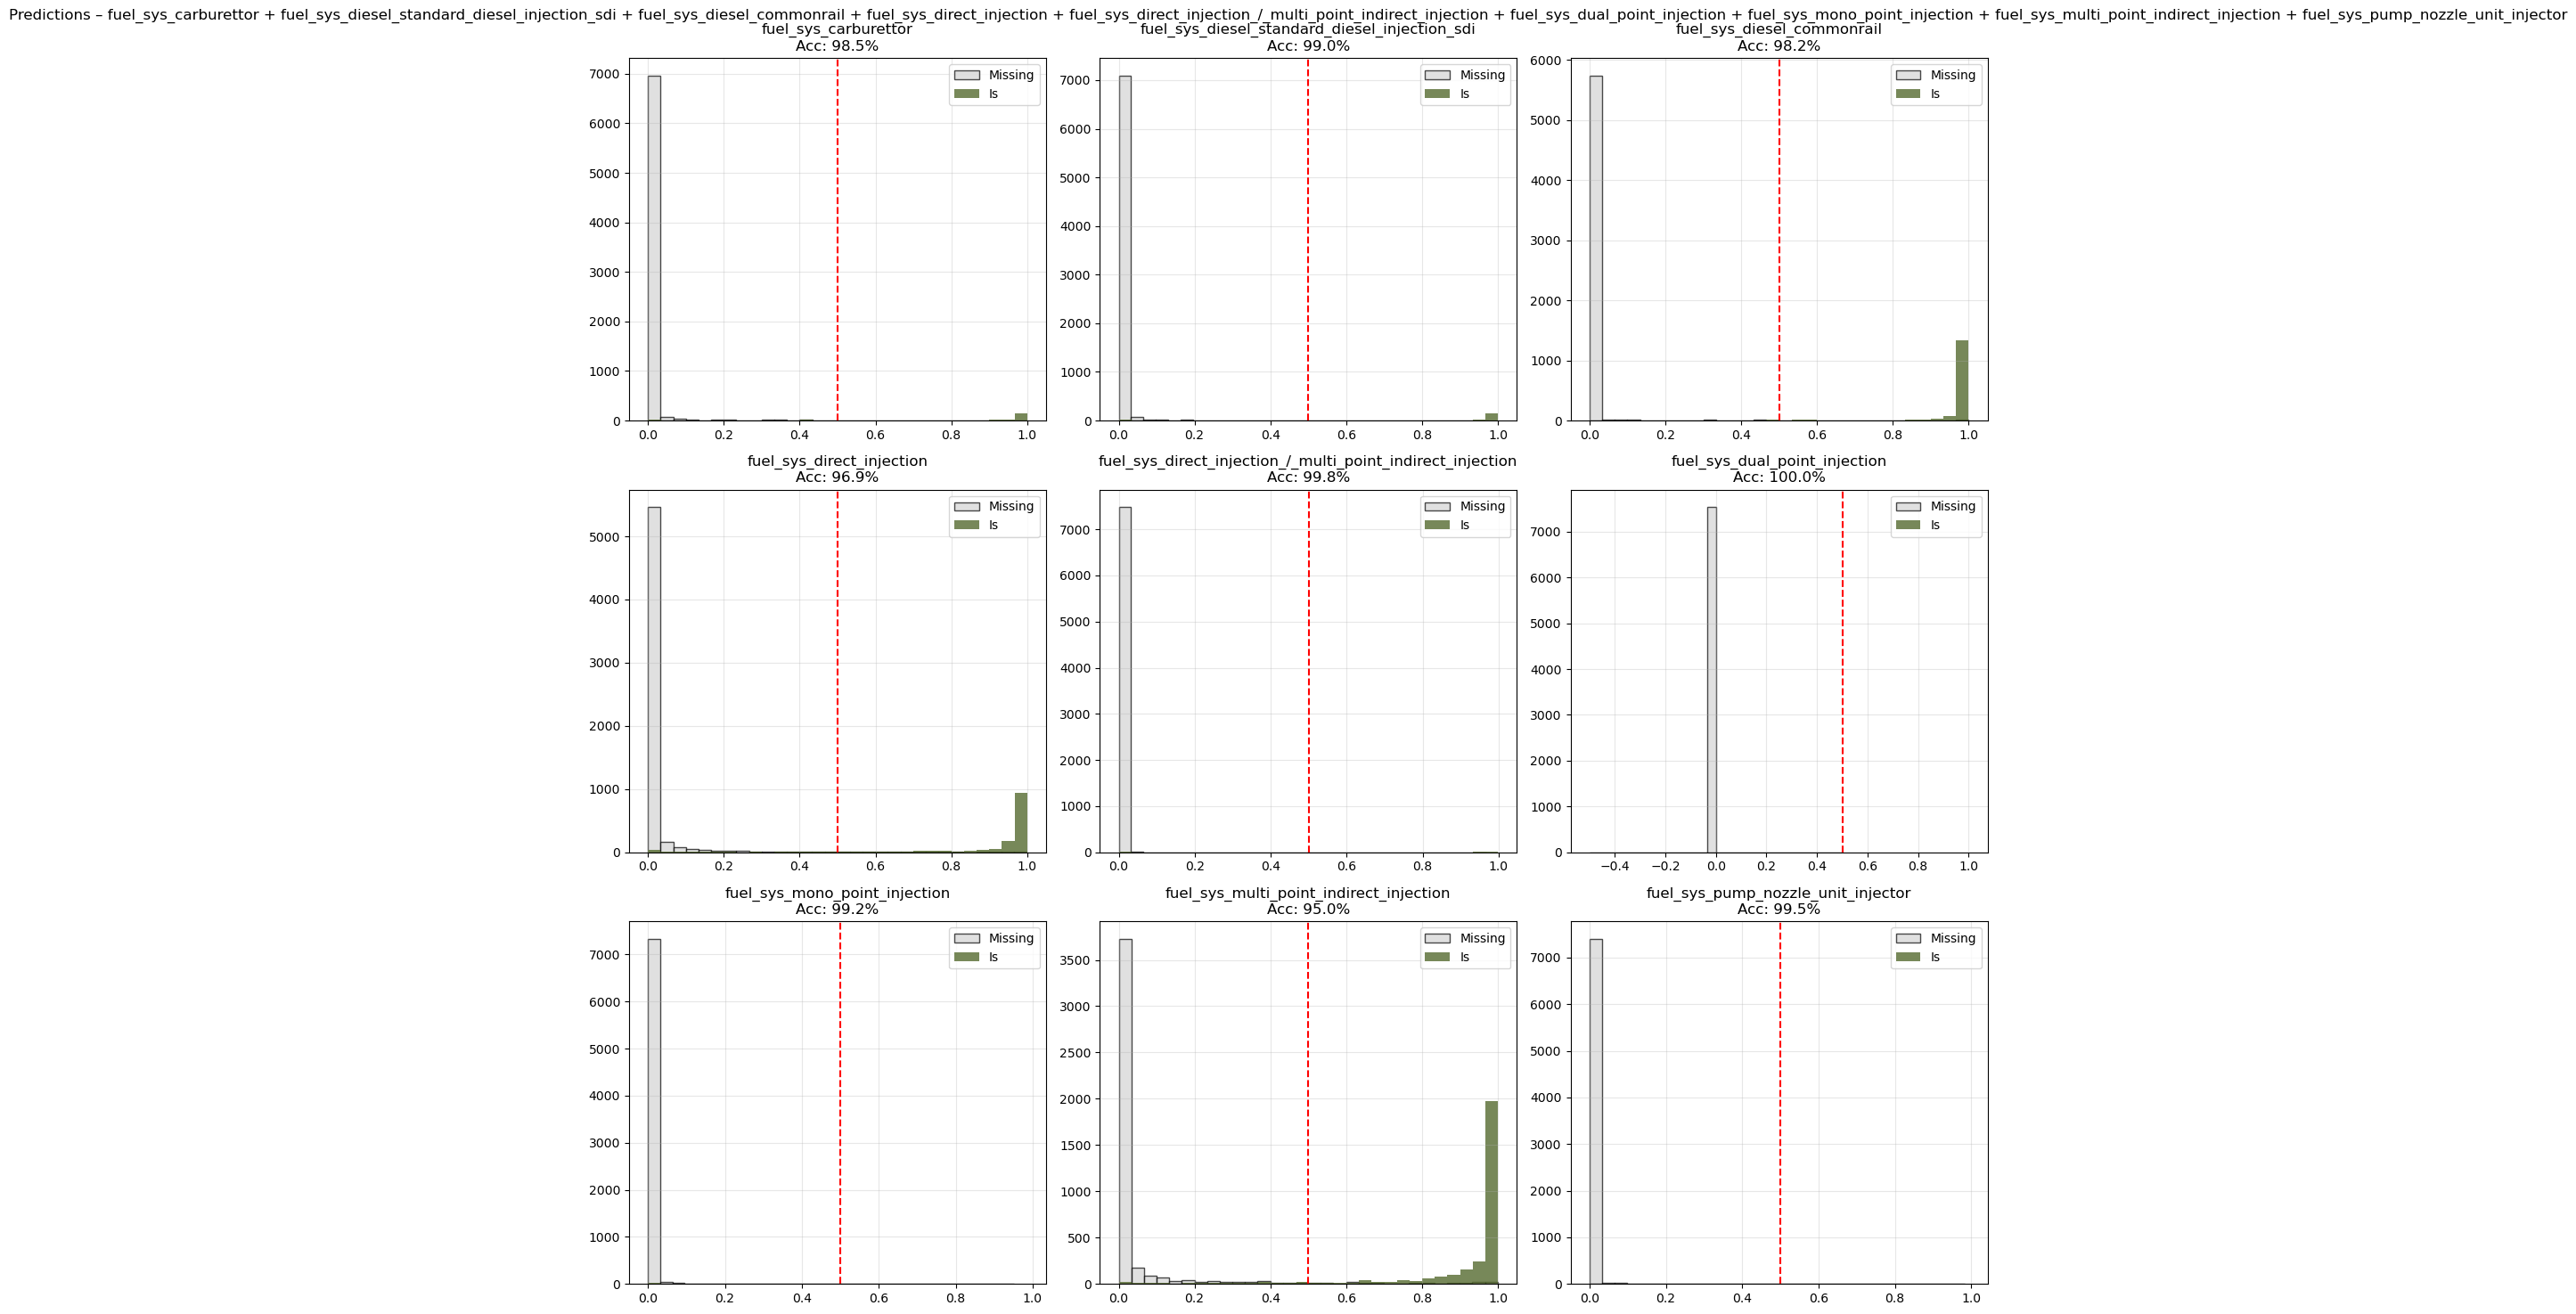

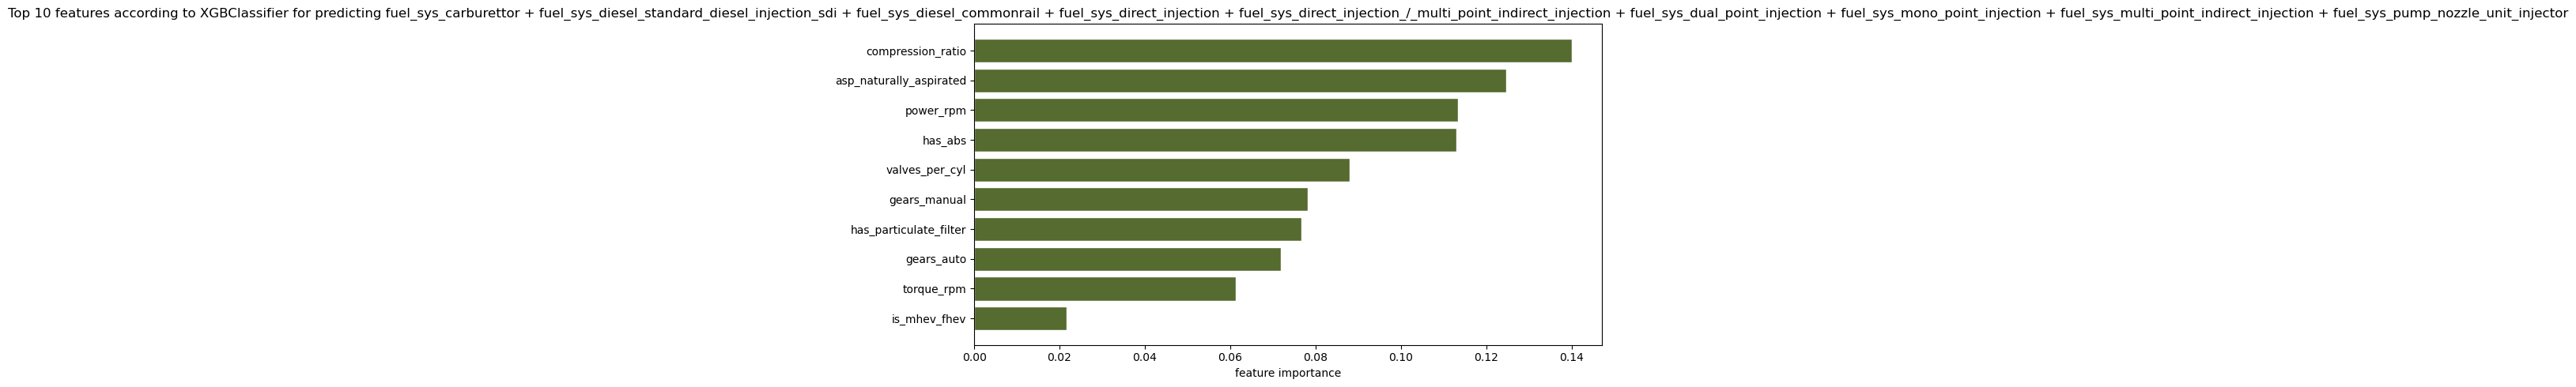

In [42]:
# 10. fuel injection
leakage = [
    'year', # vanemad autode puhul annab ära nt karburaator
    'power_kw', # otsene seos
    'is_diesel',
    'is_petrol'
]
fuel_sys_cols = [col for col in df.columns if col.startswith('fuel_sys_')]
model10_1 = predict_attribute2(df, fuel_sys_cols, leakage)
model10_2 = predict_xgboost(df, fuel_sys_cols, leakage)

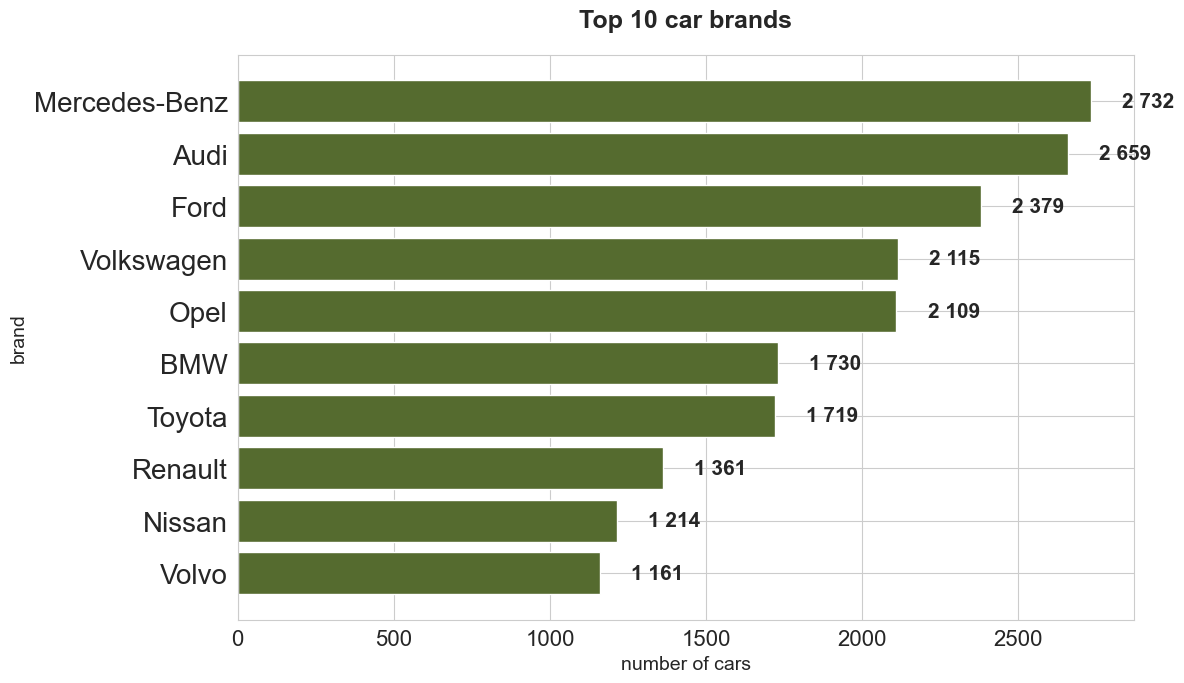

C:\Users\J\AppData\Local\Temp\ipykernel_3692\3692574164.py:41: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  body_binary = df[body_cols].applymap(lambda x: 1 if (x == 1 or x is True or (isinstance(x, str) and x.strip() != '')) else 0)


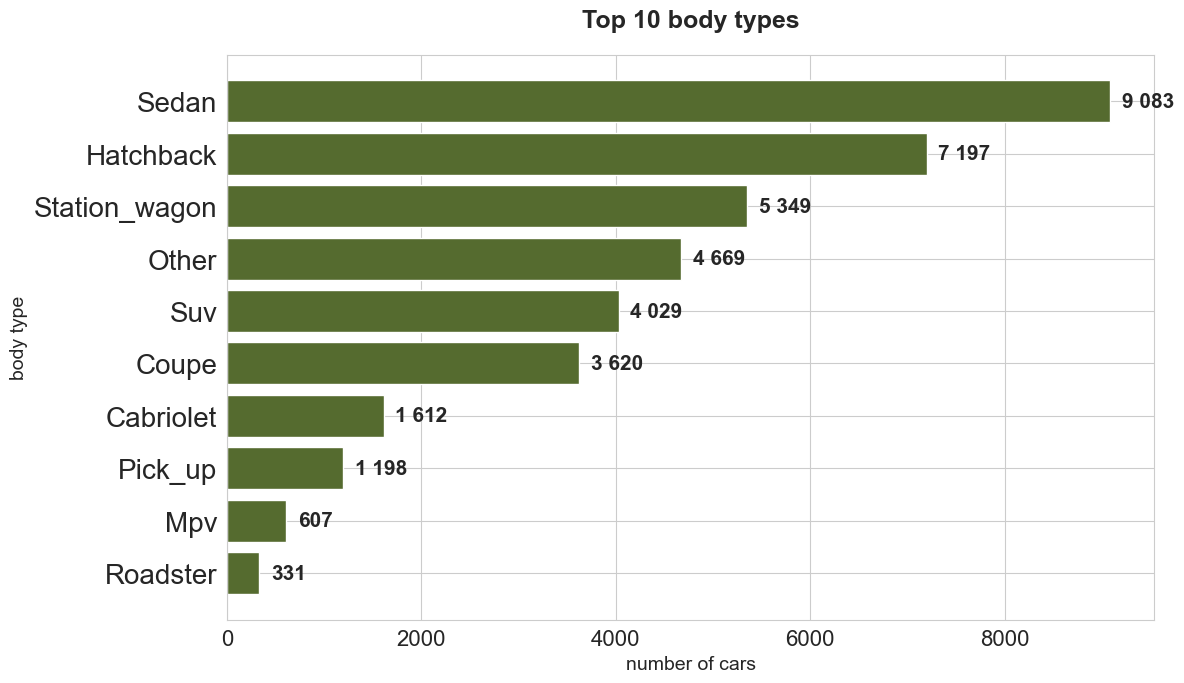

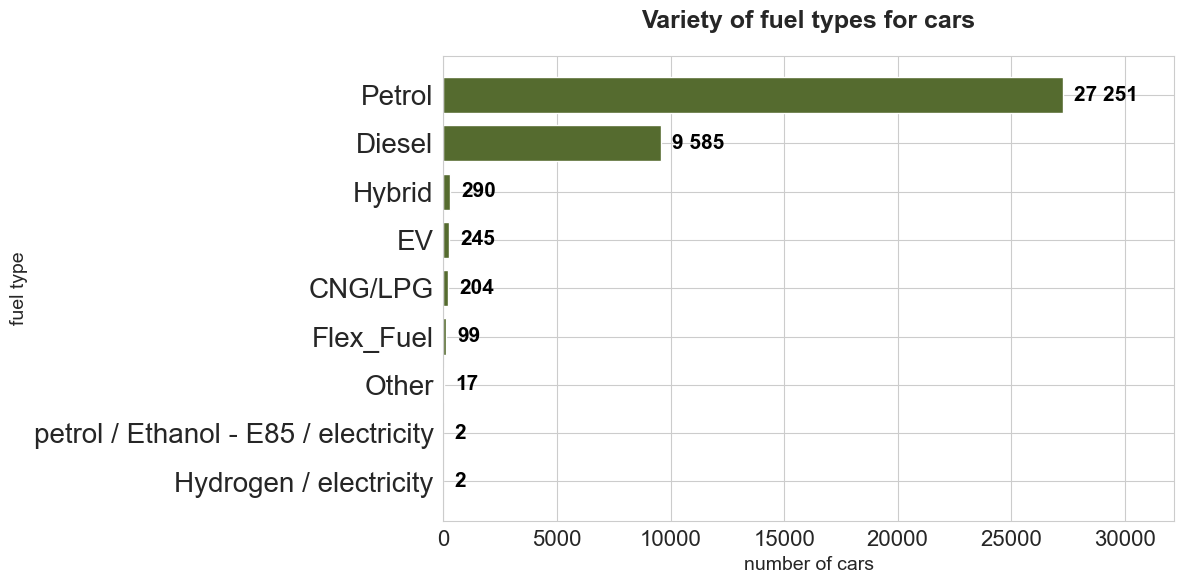

In [43]:
# Statistics

# 1. top 10 car brands
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

DARK_OLIVE = '#556B2F'

# ========================================
# 1. Top 10 car brands
top10_brands = df['brand'].value_counts().head(10)

plt.figure(figsize=(12, 7))
bars1 = plt.barh(top10_brands.index[::-1], top10_brands.values[::-1], 
                 color=DARK_OLIVE, edgecolor='white', height=0.8)
plt.title('Top 10 car brands', fontsize=18, pad=20, fontweight='bold')
plt.xlabel('number of cars', fontsize=14)
plt.ylabel('brand', fontsize=14)

for bar in bars1:
    width = bar.get_width()
    plt.text(width + 100, bar.get_y() + bar.get_height()/2, 
             f'{int(width):,}'.replace(',', ' '),
             va='center', ha='left', fontsize=15, fontweight='bold')

plt.yticks(fontsize=20)
plt.xticks(fontsize=16)

plt.tight_layout()
#plt.savefig('brands.pdf', bbox_inches='tight')
plt.show()

# ========================================
# 2. Top 10 car body types
body_cols = [col for col in df.columns if col.startswith('body_')]
body_binary = df[body_cols].applymap(lambda x: 1 if (x == 1 or x is True or (isinstance(x, str) and x.strip() != '')) else 0)
body_type_series = body_binary.idxmax(axis=1).where(body_binary.sum(axis=1) > 0, 'Unknown')
df['body_type'] = body_type_series.str.replace('body_', '', regex=False).str.capitalize()

top10_body = df['body_type'].value_counts().head(10)

plt.figure(figsize=(12, 7))
bars2 = plt.barh(top10_body.index[::-1], top10_body.values[::-1],
                 color=DARK_OLIVE, edgecolor='white', height=0.8)

plt.title('Top 10 body types', fontsize=18, pad=20, fontweight='bold')
plt.xlabel('number of cars', fontsize=14)
plt.ylabel('body type', fontsize=14)

for bar in bars2:
    width = bar.get_width()
    plt.text(width + 120, bar.get_y() + bar.get_height()/2,
             f'{int(width):,}'.replace(',', ' '),
             va='center', ha='left', fontsize=15, fontweight='bold')

plt.yticks(fontsize=20)
plt.xticks(fontsize=16)

plt.tight_layout()
#plt.savefig('body_types.pdf', bbox_inches='tight')
plt.show()

# ========================================
# 3. Distribution of fuel types
fuel_counts = df['fuel_simple'].value_counts().sort_values(ascending=True)

plt.figure(figsize=(12, 6))
bars3 = plt.barh(fuel_counts.index, fuel_counts.values,
                 color=DARK_OLIVE, edgecolor='white', height=0.75)

plt.title('Variety of fuel types for cars', fontsize=18, pad=20, fontweight='bold')
plt.xlabel('number of cars', fontsize=14)
plt.ylabel('fuel type', fontsize=14)

for bar in bars3:
    width = bar.get_width()
    plt.text(width + 500, bar.get_y() + bar.get_height()/2,
             f'{int(width):,}'.replace(',', ' '),
             va='center', ha='left', fontsize=15, fontweight='bold', color='black')

plt.yticks(fontsize=20)
plt.xticks(fontsize=16)

plt.xlim(0, fuel_counts.max() * 1.18)
plt.tight_layout()
#plt.savefig('fuel_variance.pdf', bbox_inches='tight')
plt.show()